En este jupyter notebook vamos a explorar un conjunto de datos sobre reservas de hoteles y tratar de hallar un modelo que nos permita predecir si la reserva va a ser cancelada

# Preparación del ambiente de trabajo
Importamos todas las librerías que vamos a usar


In [1]:
import pandas as pd 
import numpy as np
import sklearn as sk
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as st
from calendar import month_name

## Cargamos de datos a un dataframe

Se carga la información a un dataframe de pandas, se genera una copia y se trabaja sobre la misma

In [2]:
hotelsDfOriginal = pd.read_csv("./hotels_train.csv")
hotelsdf = hotelsDfOriginal.copy()

print("El data frame esta compuesto por "f"{hotelsdf.shape[0]}"" filas y "f"{hotelsdf.shape[1]}"" columnas")

El data frame esta compuesto por 61913 filas y 33 columnas


## Vistazo inicial

Un vistazo básico a la información contenida en el dataframe:

In [3]:
pd.concat([hotelsdf.head(2), hotelsdf.sample(5), hotelsdf.tail(2)])

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,NaN,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
3395,City Hotel,45,2015,November,47,19,2,8,1,0.0,...,NaN,0,Transient,69.24,0,0,Canceled,2015-10-14,b708c044-758a-4688-9ce0-666cfe65762d,1
39032,Resort Hotel,159,2017,March,11,14,6,15,2,0.0,...,NaN,0,Transient,70.30,0,2,Check-Out,2017-04-04,5a2db98d-8cff-4162-9d1f-b9df6cc60885,0
40642,City Hotel,173,2017,June,24,11,2,3,2,0.0,...,NaN,0,Transient,140.00,0,0,Canceled,2016-12-20,30fb7ae4-e4a6-4989-a34f-2c94e57ee01b,1
8491,City Hotel,243,2017,July,30,26,0,4,2,0.0,...,NaN,0,Transient,110.00,0,0,Canceled,2016-11-25,8dd45933-ccd6-4e51-9830-aee89c168c95,1
40383,Resort Hotel,115,2016,June,25,12,2,0,2,0.0,...,NaN,0,Transient,81.62,0,2,Check-Out,2016-06-14,94191518-fc53-4dfc-9b5b-5df929ea65b4,0
61911,Resort Hotel,143,2015,October,41,10,2,5,2,0.0,...,NaN,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1
61912,City Hotel,57,2016,April,17,17,2,5,2,0.0,...,NaN,0,Transient,143.29,0,0,Canceled,2016-04-09,7137e599-4442-41fb-b147-4aba9f344e38,1


Renombramos las columnas del dataframe con nombres mas claros

In [4]:
nuevas_columnas = {
    'adr':'average_daily_rate',
    'adults':'adult_num',
    'agent':'agent_id',
    'arrival_date_day_of_month':'arrival_month_day',
    'arrival_date_month':'arrival_month',
    'arrival_date_week_number':'arrival_week_number',
    'arrival_date_year':'arrival_year',
    'assigned_room_type':'assigned_room_type',
    'babies':'babies_num',
    'booking_changes':'booking_changes_num',
    'children':'children_num',
    'company':'company_id',
    'country':'country',
    'customer_type':'customer_type',
    'days_in_waiting_list':'days_in_waiting_list',
    'deposit_type':'deposit_type',
    'distribution_channel':'distribution_channel',
    'hotel':'hotel_name',
    'id':'booking_id',
    'is_canceled':'is_canceled',
    'is_repeated_guest':'is_repeated_guest',
    'lead_time':'lead_time',
    'market_segment':'market_segment_type',
    'meal':'meal_type',
    'previous_bookings_not_canceled':'previous_bookings_not_canceled_num',
    'previous_cancellations':'previous_cancellations_num',
    'required_car_parking_spaces':'required_car_parking_spaces_num',
    'reserved_room_type':'reserved_room_type',
    'stays_in_weekend_nights':'weekend_nights_num',
    'stays_in_week_nights':'week_nights_num',
    'total_of_special_requests':'special_requests_num',
}

hotelsdf.rename(columns = nuevas_columnas, inplace = True)

Por otro lado, podemos observar que tipo de dato almacena cada columna y cuales tienen datos faltantes

In [5]:
hotelsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61913 entries, 0 to 61912
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   hotel_name                          61913 non-null  object 
 1   lead_time                           61913 non-null  int64  
 2   arrival_year                        61913 non-null  int64  
 3   arrival_month                       61913 non-null  object 
 4   arrival_week_number                 61913 non-null  int64  
 5   arrival_month_day                   61913 non-null  int64  
 6   weekend_nights_num                  61913 non-null  int64  
 7   week_nights_num                     61913 non-null  int64  
 8   adult_num                           61913 non-null  int64  
 9   children_num                        61909 non-null  float64
 10  babies_num                          61913 non-null  int64  
 11  meal_type                           61913

# Analisis univariado
Vamos a dividir las variables en cuantitativas y cualitativas.

|     Nombre de la variable           |       Tipo      |      Descripcion         |
| ----------------------------------- | --------------- | ------------------------ |  
| average_daily_rate                  | Cuantitativa    | Promedio de la ganancia diaria, por habitación                              |
| adult_num                           | Cuantitativa    |           Numero de adultos en la reserva              |
| agent_id                            | Cualitativa     | ID de la agencia de viaje que hizo la reserva                         |
| arrival_month_day                   | Cuantitativa    | Día del mes que llego                         |
| arrival_month                       | Cualitativa     |  Mes de llegada                        |
| arrival_week_number                 | Cuantitativa    |   Numero de la semana de llegada                       |
| arrival_year                        | Cuantitativa    |    Año de llegada                      |
| assigned_room_type                  | Cualitativa     |     Tipo de cuarto                    |
| babies_num                          | Cuantitativa    |      Cantidad de bebes                     |
| booking_changes_num                 | Cuantitativa    |      Cantidad de cambios a la reserva hasta el día de llegada                    |
| booking_id                          | Cualitativa     |        ID de la reserva                  |
| children_num                        | Cuantitativa    |         Cantidad de niños                 |
| company_id                          | Cualitativa     |         ID  de la compañía que hizo la reserva                 |
| country                             | Cualitativa     |        País de origen                  |
| customer_type                       | Cualitativa     |         Tipos de reserva                 |
| days_in_waiting_list                | Cuantitativa    |         Cantidad de días en la lista de espera                 |
| deposit_type                        | Cualitativa     |          Tipo de deposito para la reserva                |
| distribution_channel                | Cualitativa     |  Medio por el cual se hizo la reserva                        |
| hotel_name                          | Cualitativa     |  Nombre del hotel                        |
| is_canceled                         | Cualitativa     |   Si la reserva fue cancelada o no                       |
| is_repeated_guest                   | Cualitativa     |    Si el invitado ya había ido al hotel                      |
| lead_time                           | Cuantitativa    |   Cantidad de días entre el día que se realizo la reserva y el día de llegada                       |
| market_segment_type                 | Cualitativa     |       Categoría de mercado                   |
| meal_type                           | Cualitativa     |       Tipo de comida pedida                   |
| previous_bookings_not_canceled_num  | Cuantitativa    |       Cantidad de reservas previas no canceladas                   |
| previous_cancellations_num          | Cuantitativa    |       Cantidad de reservas canceladas                   |
| required_car_parking_spaces_num     | Cuantitativa    |       Cantidad de lugares de estacionamiento pedido                  |
| reserved_room_type                  | Cualitativa     |       Tipo de cuarto reservado                   |
| weekend_nights_num                  | Cuantitativa    |        Cantidad de noches de fin de semana que estuvo                  |
| week_nights_num                     | Cuantitativa    |         Cantidad de noches de semana que estuvo                 |
| special_requests_num                | Cuantitativa    |         Cantidad de pedidos especiales hechos                 |


## Cuantitativas

Se trabaja inicialmente sobre las variables que han sido identificadas como cuantitativas, se grafican y se intenta realizar la identificación de outliers, por otro lado, aquellas que de un análisis exploratorio previo arrojaron la existencia de *nulls/nans* se realiza algún tipo de reemplazo por el valor más conveniente

Creamos una lista con todas las variables cuantitativas

In [6]:
cuantitativas = [
"adult_num",
"arrival_month_day",
"arrival_week_number",
"arrival_year",
"average_daily_rate",
"babies_num",
"booking_changes_num",
"children_num",
"days_in_waiting_list",
"lead_time",
"previous_bookings_not_canceled_num",
"previous_cancellations_num",
"required_car_parking_spaces_num",
"special_requests_num",
"weekend_nights_num",
"week_nights_num",
]

### Adult number 

Realizamos un análisis sobre la variable adult number

#### Valores estadísticos relevantes 

In [7]:
hotelsdf.adult_num.describe()

count    61913.000000
mean         1.862791
std          0.589066
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         55.000000
Name: adult_num, dtype: float64

Dentro de los parámetros estadísticos representativos observamos un mínimo de 0 adultos y un máximo de 55, ambos representando registros con valores anormales. 

#### Gráfica de distribución

Para mas información sobre la frecuencia de los valores se grafican las frecuencias

Text(0, 0.5, 'Frecuencia')

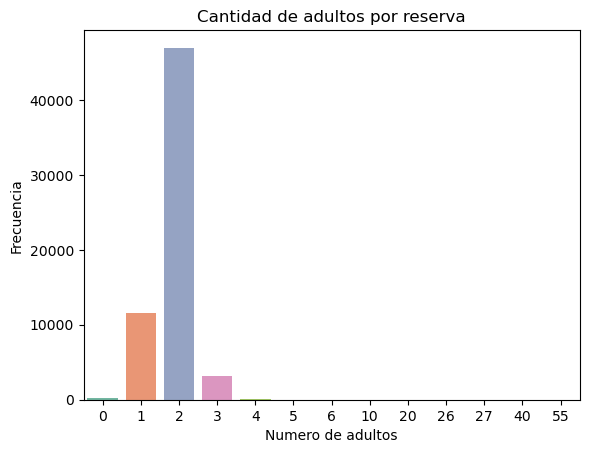

In [8]:
sns.countplot(data = hotelsdf, x = 'adult_num', palette= 'Set2')
plt.title('Cantidad de adultos por reserva')
plt.xlabel('Numero de adultos')
plt.ylabel('Frecuencia')

#### Outliers

In [9]:
a_eliminar_con_cero = hotelsdf[hotelsdf['adult_num'] == 0]
a_eliminar_con_cero 

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
96,City Hotel,23,2016,May,21,21,2,4,0,2.0,...,NaN,0,Transient,128.49,0,0,Canceled,2016-05-05,dcaf076d-bd38-47dd-8d9d-16be09cd5b08,1
212,City Hotel,315,2017,July,27,7,0,1,0,2.0,...,NaN,0,Transient,91.85,0,2,Canceled,2016-09-19,55c9b5f9-b5d0-49a2-9348-c6476a0bd772,1
270,City Hotel,4,2017,February,8,21,0,3,0,0.0,...,NaN,0,Transient-Party,0.00,0,0,Canceled,2017-02-17,6a48e05e-c36a-41d0-b7e0-5f8b92dab109,1
326,City Hotel,53,2016,November,49,29,0,4,0,2.0,...,NaN,0,Transient,77.86,0,2,Check-Out,2016-12-03,74fe3153-e2ae-4650-a375-05fc52881a56,0
464,City Hotel,64,2015,October,42,16,2,3,0,0.0,...,NaN,0,Transient-Party,0.00,0,0,Check-Out,2015-10-21,cfe370c2-298a-4de8-82fd-f8d418febd7f,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59982,City Hotel,44,2016,February,7,8,1,3,0,2.0,...,NaN,0,Transient-Party,66.50,0,1,Canceled,2016-01-26,8b700cc2-903e-4400-9c68-aba04d69de38,1
60837,City Hotel,33,2017,May,19,9,0,1,0,0.0,...,NaN,0,Transient,200.00,0,0,Check-Out,2017-05-10,070652d9-948b-47a3-bb96-113627bb5558,0
60994,City Hotel,11,2016,August,34,19,0,1,0,2.0,...,NaN,0,Transient,127.60,0,1,Check-Out,2016-08-20,17552f62-53e5-4bdf-877d-c2b9769ec27a,0
61003,City Hotel,57,2016,November,46,9,0,2,0,0.0,...,NaN,0,Transient,165.38,0,2,Check-Out,2016-11-11,c6b4f9bb-b1f7-4765-a4af-5846748c13f4,0


In [10]:
a_eliminar_mayores_3 = hotelsdf[hotelsdf['adult_num'] > 3]
a_eliminar_mayores_3

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
2051,Resort Hotel,19,2017,June,24,12,1,4,4,0.0,...,NaN,0,Transient,260.00,0,0,Canceled,2017-05-31,ca064aea-95d6-4f0e-a8f3-788c0876935d,1
2291,City Hotel,109,2016,December,50,8,0,3,4,0.0,...,NaN,0,Transient,182.18,0,1,Check-Out,2016-12-11,06a8cadf-ec95-4070-9baa-19233e04fe07,0
3962,Resort Hotel,328,2015,October,41,6,2,5,5,0.0,...,NaN,0,Group,0.00,0,0,Canceled,2015-01-02,54e377ff-6236-44f0-81e7-ab8750d6998a,1
4064,Resort Hotel,304,2015,September,36,3,0,3,40,0.0,...,NaN,0,Group,0.00,0,0,Canceled,2015-01-02,ebb06f2f-1c79-490c-ae9f-8f7ba838d328,1
4730,Resort Hotel,27,2015,August,36,31,1,3,4,0.0,...,NaN,0,Transient,256.50,0,0,Check-Out,2015-09-04,b13d5d16-4b7a-4b68-937f-dca166a78864,0
11551,Resort Hotel,72,2016,April,14,1,2,5,4,1.0,...,NaN,0,Transient,134.06,0,0,Check-Out,2016-04-08,492c83e9-4bc9-42b1-8bfa-c9bef3997225,0
11830,Resort Hotel,334,2015,October,42,12,2,5,20,0.0,...,NaN,0,Group,0.00,0,0,Canceled,2015-01-02,b169d836-a93c-43a3-8bb4-9ec2afa66483,1
12873,City Hotel,21,2016,July,30,17,2,1,4,0.0,...,NaN,0,Transient,299.33,0,0,Canceled,2016-07-07,e3c99ecb-c144-4c4a-960c-42c104b9dabb,1
13101,Resort Hotel,328,2015,October,41,6,2,5,6,0.0,...,NaN,0,Group,0.00,0,0,Canceled,2015-01-02,653ecbda-b99c-4aaf-b118-3c1877b57abb,1
17204,City Hotel,75,2017,March,9,3,2,3,4,0.0,...,NaN,0,Transient,202.51,0,0,Canceled,2016-12-19,0790d547-0b99-418a-8e2f-0e4286e4db45,1


In [11]:
print(f'Total de registros a eliminar: {len(a_eliminar_con_cero) + len(a_eliminar_mayores_3)}')

Total de registros a eliminar: 238


Existen 41 registros con valores superiores a 3, los cuales representan outliers. A su vez, se incluyen a estos registros aquellos valores identificados previamente 

#### Ajustes de valor

Eliminamos dichos valores que representan un porcentaje ínfimo y pueden llegar a desviar las futuras predicciones

In [12]:
hotelsdf.drop(a_eliminar_con_cero.index, inplace = True)
hotelsdf.drop(a_eliminar_mayores_3.index, inplace = True)
hotelsdf.reset_index(drop=True)
hotelsdf[(hotelsdf["adult_num"] > 4) | hotelsdf['adult_num'] == 0]

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled


Por otro lado realizamos de nuevo las gráficas de la distribución para verificar que no cambie significativamente

Text(0, 0.5, 'Frecuencia')

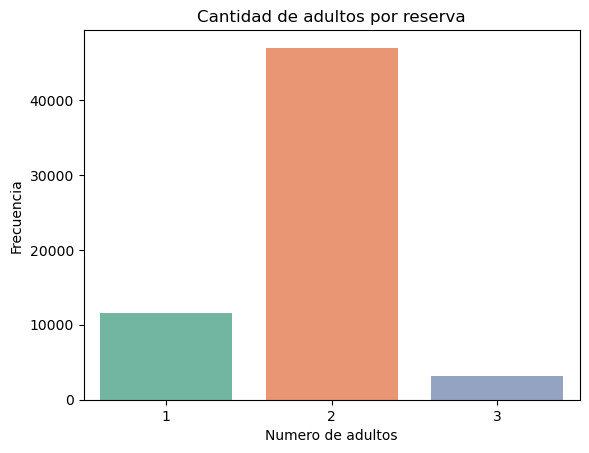

In [13]:
sns.countplot(data = hotelsdf, x = 'adult_num', palette= 'Set2')
plt.title('Cantidad de adultos por reserva')
plt.xlabel('Numero de adultos')
plt.ylabel('Frecuencia')

### arrival month day

#### Valores estadisticos relevantes

In [14]:
hotelsdf["arrival_month_day"].describe()

count    61675.000000
mean        15.784532
std          8.795480
min          1.000000
25%          8.000000
50%         16.000000
75%         23.000000
max         31.000000
Name: arrival_month_day, dtype: float64

Los parámetros estadísticos relevantes no muestran por si solos valores irregulares en el análisis

#### Gráfica de distribución

Una gráfica puede llegar a esclarecer o identificar valores fuera de lo común dentro del dataframe

Text(0, 0.5, 'Frecuencia')

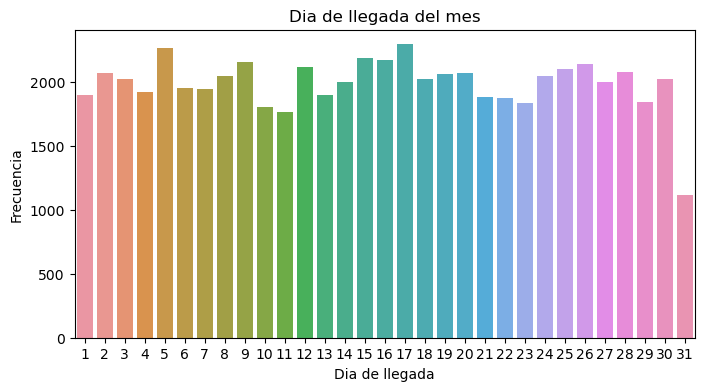

In [15]:
plt.figure(figsize=(8,4))
sns.countplot(data = hotelsdf, x = 'arrival_month_day')
plt.title("Dia de llegada del mes")
plt.xlabel(xlabel = 'Dia de llegada')
plt.ylabel(ylabel = 'Frecuencia')

El análisis uní variado de arrival month day no arroja información relevante, pero por otro lado, muestra que la variable no presenta ningún valor inesperado y desmuestra que no hay un día de predilecto del mes

Text(0, 0.5, 'Frecuencia')

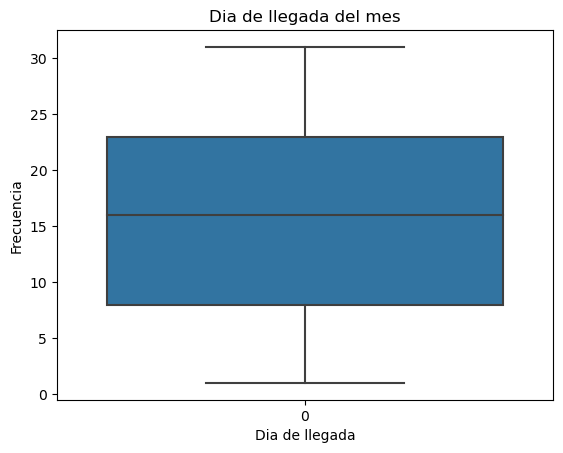

In [16]:
plt.xlabel(xlabel = 'Dia de llegada')
sns.boxplot(data = hotelsdf['arrival_month_day'])
plt.title("Dia de llegada del mes")
plt.ylabel(ylabel = 'Frecuencia')

Por lado un boxplot afirma las concluciones derivadas del gráfico anterior 

### arrival week number 

#### Valores estadisticos relevantes

In [17]:
hotelsdf.arrival_week_number.describe()

count    61675.000000
mean        27.209664
std         13.520366
min          1.000000
25%         16.000000
50%         28.000000
75%         38.000000
max         53.000000
Name: arrival_week_number, dtype: float64

Un vistazo inicial a los parámetros estadisticos no muestra inconsistencias en los registros

#### Gráfica de distribución

Text(0, 0.5, 'Frecuencia')

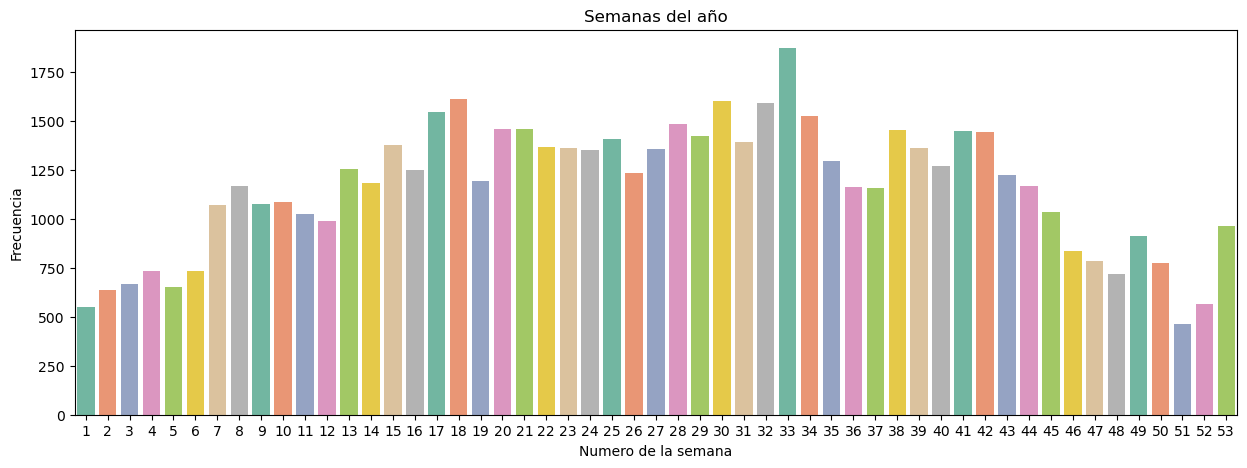

In [18]:
plt.figure(figsize=(15,5))
sns.countplot(data = hotelsdf, x = 'arrival_week_number', palette='Set2')
plt.title('Semanas del año')
plt.xlabel('Numero de la semana')
plt.ylabel('Frecuencia')

De la gráfica concluimos que no existen outliers entre los registros 

### arrival year 

#### Valores estadisticos relevantes

In [19]:
hotelsdf.arrival_year.describe()

count    61675.000000
mean      2016.154714
std          0.708558
min       2015.000000
25%       2016.000000
50%       2016.000000
75%       2017.000000
max       2017.000000
Name: arrival_year, dtype: float64

#### Gráfica de distribución

Text(0.5, 1.0, 'Año de las reservas')

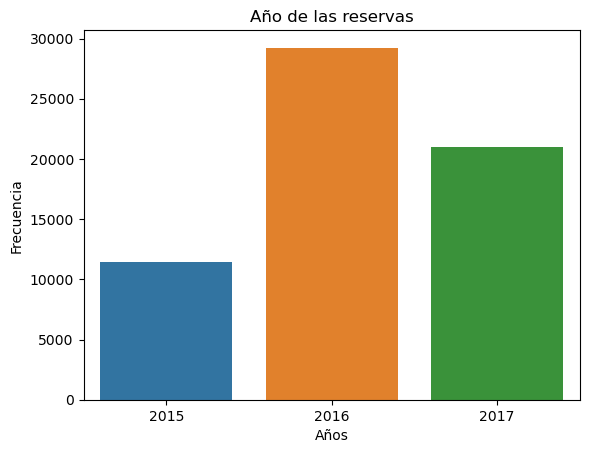

In [20]:
sns.countplot(data = hotelsdf, x = 'arrival_year')
plt.xlabel('Años')
plt.ylabel('Frecuencia')
plt.title('Año de las reservas')

Todos los registros corresponden a los años: 2015, 2016 y 2017 siendo el año 2016 el mas frecuente entre los registros

### Average Daily Rate

Realizamos un analisis sobre la variable average daily rate

#### Valores estadisticos relevantes 

In [21]:
hotelsdf.average_daily_rate.describe()

count    61675.000000
mean       102.505378
std         47.595499
min         -6.380000
25%         70.000000
50%         95.000000
75%        126.000000
max        510.000000
Name: average_daily_rate, dtype: float64

#### Grafica de distribución

Text(0.5, 1.0, 'Distribucion del Precio promedio de renta diaria')

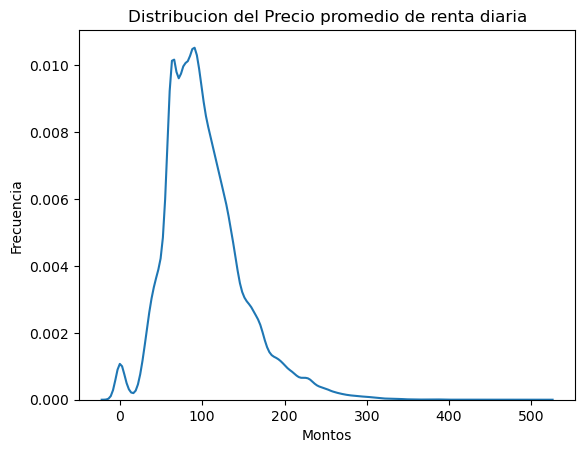

In [22]:
sns.kdeplot(data = hotelsdf.average_daily_rate)
plt.xlabel(xlabel = 'Montos')
plt.ylabel(ylabel = 'Frecuencia')
plt.title('Distribucion del Precio promedio de renta diaria')

#### Outliers

Del grafico anterior se observan registros de average daily rate los cuales tienen asignados 0, se debe estudiar a que se deben esos valores, asi como tambien tratar el valor negativo que aparece como mínimo, por otro lado, analizamos cuantos de los precios presentes en los registros presentan una desviacion considerable de los valores esperados

Text(0, 0.5, 'Montos')

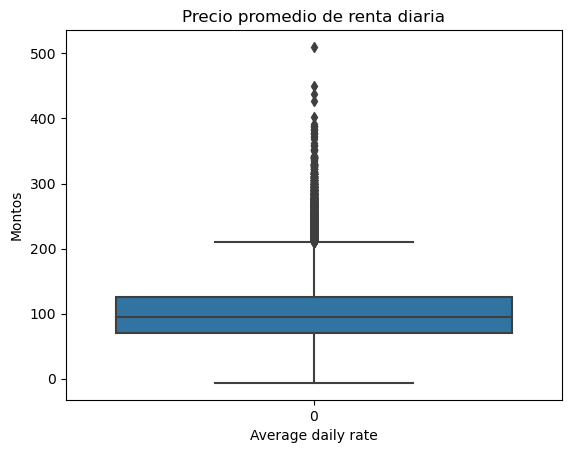

In [23]:
sns.boxplot(data = hotelsdf['average_daily_rate'])
plt.title("Precio promedio de renta diaria")
plt.xlabel('Average daily rate')
plt.ylabel('Montos')

In [24]:

valores_con_cero = len(hotelsdf[hotelsdf['average_daily_rate'] <= 0])
total_valores = len(hotelsdf.average_daily_rate)
porcentaje_con_cero = valores_con_cero/total_valores
print(f" Los de adrs que registran un valor de 0 representa un porcentaje de:{porcentaje_con_cero}' por lo tanto considerando que no son representativos, eliminamos dichos registros inconsistentes ")

 Los de adrs que registran un valor de 0 representa un porcentaje de:0.013084718281313336' por lo tanto considerando que no son representativos, eliminamos dichos registros inconsistentes 


eliminar valores con 0

In [25]:
a_eliminar_con_cero = hotelsdf[hotelsdf['average_daily_rate'] <= 0].index
hotelsdf.drop(a_eliminar_con_cero, inplace = True)
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,NaN,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,NaN,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,NaN,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,NaN,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60863,Resort Hotel,24,2017,January,4,27,0,2,2,0.0,...,NaN,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1
60864,City Hotel,0,2016,September,36,2,0,1,1,0.0,...,NaN,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0
60865,City Hotel,10,2017,May,19,8,1,2,1,0.0,...,153.0,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0
60866,Resort Hotel,143,2015,October,41,10,2,5,2,0.0,...,NaN,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1


#### Ajustes de valor

Utilizamos Z-score para clasificar las desviasiones presentes en los valores


In [26]:

media_requisitos=np.mean(hotelsdf.average_daily_rate)

std_ard=np.std(hotelsdf.average_daily_rate)

hotelsdf['z_adr']=(hotelsdf.average_daily_rate - media_requisitos)/std_ard

hotelsdf['z_adr']=st.zscore(hotelsdf.average_daily_rate)
hotelsdf[(hotelsdf['z_adr'] > 3) | (hotelsdf['z_adr'] < -2)]

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled,z_adr
238,Resort Hotel,38,2017,August,32,7,1,5,2,1.0,...,0,Transient,302.5,0,1,Check-Out,2017-08-13,988bf050-6aa8-4211-ac09-752c4e58bcbd,0,4.279754
307,City Hotel,31,2017,May,20,19,0,1,3,0.0,...,0,Transient,279.0,0,0,Canceled,2017-04-20,2094b29e-7f3e-4846-8c87-4a73683bc804,1,3.773428
320,Resort Hotel,212,2017,July,28,14,3,7,2,2.0,...,0,Transient,289.6,0,0,Canceled,2017-06-14,21d96765-304c-437f-b745-f82e8a41e471,1,4.001814
439,City Hotel,21,2017,July,27,6,0,1,2,2.0,...,0,Transient,307.0,0,0,Canceled,2017-06-15,f4330103-9555-4f10-b40b-52fc138e341c,1,4.376710
481,City Hotel,145,2016,August,32,4,0,3,2,3.0,...,0,Transient,269.3,0,1,Check-Out,2016-08-07,c5ca8a03-6e90-4165-853e-a7437487410c,0,3.564434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61689,City Hotel,72,2017,July,27,2,2,0,3,0.0,...,0,Transient,247.0,0,1,Check-Out,2017-07-04,dfb7933d-560b-4a82-a127-919e534351d1,0,3.083964
61745,Resort Hotel,205,2017,August,31,2,1,4,2,2.0,...,0,Transient,300.4,0,2,Canceled,2017-01-17,f4bd2623-14df-4912-8abf-b698381ac634,1,4.234508
61830,Resort Hotel,72,2017,July,30,28,1,2,2,0.0,...,0,Transient,271.0,0,2,Check-Out,2017-07-31,0d1b3abd-3c4c-46c0-a829-11bacf4033ff,0,3.601062
61834,Resort Hotel,95,2017,July,30,24,1,4,2,2.0,...,0,Transient,305.0,0,0,Canceled,2017-06-02,6dec4274-f4ec-4c4a-88fb-cb6b4878745a,1,4.333618


Graficamos el Z-score del adr


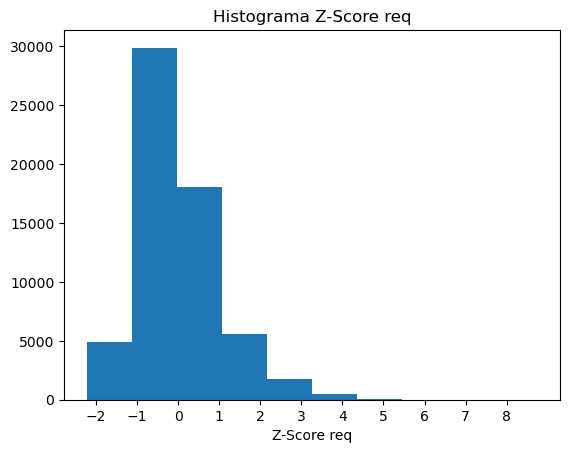

In [27]:
plt.hist(hotelsdf.z_adr)
plt.title('Histograma Z-Score req')
plt.xlabel('Z-Score req')
plt.xticks([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
plt.show()

In [28]:
desviacion_uno = hotelsdf[(hotelsdf['z_adr'] > 3)]
desviacion_dos = hotelsdf[(hotelsdf['z_adr'] < -2)]
hotelsdf.drop(desviacion_uno.index, inplace = True)
hotelsdf.drop(desviacion_dos.index, inplace = True)
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled,z_adr
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1,0.250695
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0,-1.332919
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0,2.696140
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1,-0.621908
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0,-0.621908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59917,Resort Hotel,24,2017,January,4,27,0,2,2,0.0,...,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1,-1.203644
59918,City Hotel,0,2016,September,36,2,0,1,1,0.0,...,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0,0.972479
59919,City Hotel,10,2017,May,19,8,1,2,1,0.0,...,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0,-0.190993
59920,Resort Hotel,143,2015,October,41,10,2,5,2,0.0,...,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1,-1.461116


In [29]:
total_valores = len(hotelsdf.average_daily_rate)
cantidad_a_eliminar = desviacion_uno.average_daily_rate.count() + desviacion_dos.average_daily_rate.count()
print("Vamos a eliminar " + str(cantidad_a_eliminar)  + " valores ya son valores que tienen una desviacion estandar muy marcada con  respecto al resto de los valores. Ademas, estos valores representan un " +  str(cantidad_a_eliminar/total_valores) + " porcentaje del total")

Vamos a eliminar 946 valores ya son valores que tienen una desviacion estandar muy marcada con  respecto al resto de los valores. Ademas, estos valores representan un 0.015787190013684456 porcentaje del total


Graficamos nuevamente con el proposito de verificar la nueva distribución adquirida luego de la modificacion 



Text(0.5, 1.0, 'Distribucion del average daily rate')

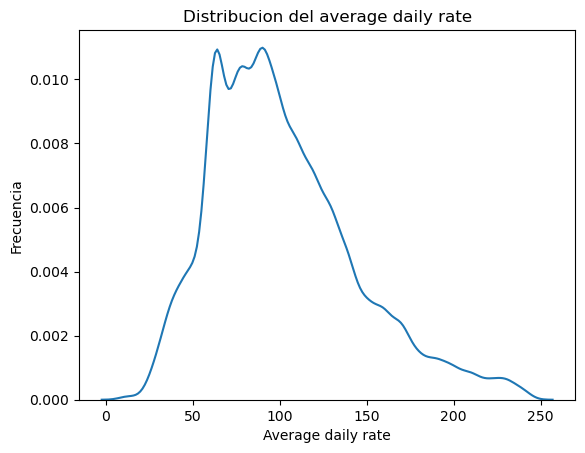

In [30]:
data = hotelsdf.average_daily_rate
sns.kdeplot(data = data)
plt.xlabel(xlabel = 'Average daily rate')
plt.ylabel(ylabel = 'Frecuencia')
plt.title('Distribucion del average daily rate')

In [31]:
hotelsdf.drop(labels = 'z_adr', inplace = True, axis = 1)
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,NaN,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,NaN,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,NaN,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,NaN,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59917,Resort Hotel,24,2017,January,4,27,0,2,2,0.0,...,NaN,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1
59918,City Hotel,0,2016,September,36,2,0,1,1,0.0,...,NaN,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0
59919,City Hotel,10,2017,May,19,8,1,2,1,0.0,...,153.0,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0
59920,Resort Hotel,143,2015,October,41,10,2,5,2,0.0,...,NaN,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1


### babies number 

#### Valores estadisticos relevantes


In [32]:
hotelsdf.babies_num.describe()

count    59922.000000
mean         0.006826
std          0.090448
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          9.000000
Name: babies_num, dtype: float64

#### Grafica de distribución

Text(0.5, 1.0, 'Numero de bebes por reserva')

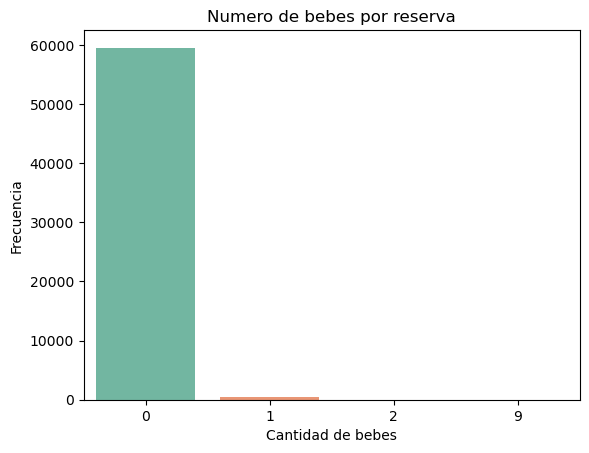

In [33]:
eje_y = hotelsdf.babies_num.value_counts()
eje_x = eje_y.index.tolist()
sns.barplot(y = eje_y, x = eje_x, palette='Set2')
plt.xlabel('Cantidad de bebes')
plt.ylabel(ylabel='Frecuencia')
plt.title('Numero de bebes por reserva')

#### Outliers

In [34]:
hotelsdf[(hotelsdf.babies_num >= 1) & (hotelsdf.adult_num < 1)]

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled


#### Ajustes de valor

In [35]:
hotelsdf.drop(hotelsdf[hotelsdf.babies_num == 9].index, inplace = True)
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,NaN,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,NaN,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,NaN,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,NaN,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59916,Resort Hotel,24,2017,January,4,27,0,2,2,0.0,...,NaN,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1
59917,City Hotel,0,2016,September,36,2,0,1,1,0.0,...,NaN,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0
59918,City Hotel,10,2017,May,19,8,1,2,1,0.0,...,153.0,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0
59919,Resort Hotel,143,2015,October,41,10,2,5,2,0.0,...,NaN,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1


### booking changes number 

#### Valores estadisticos relevantes

In [36]:
hotelsdf.booking_changes_num.describe()

count    59921.000000
mean         0.189066
std          0.594914
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         17.000000
Name: booking_changes_num, dtype: float64

#### Grafica de distribución

Text(0.5, 1.0, 'Cantidad de cambios por reserva')

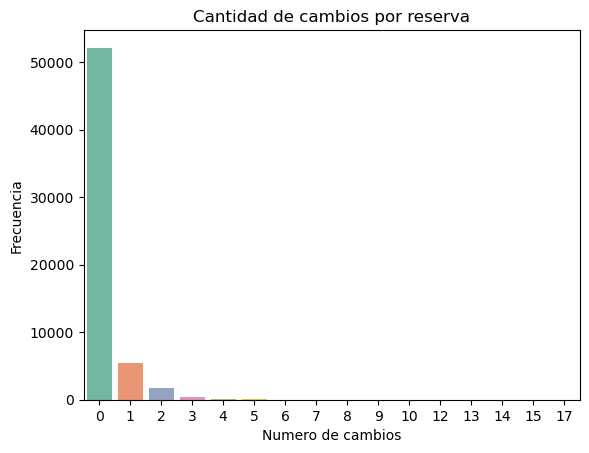

In [37]:
eje_y = hotelsdf.booking_changes_num.value_counts()
eje_x = eje_y.index.tolist()
sns.barplot(y = eje_y, x = eje_x, palette='Set2')
plt.xlabel('Numero de cambios')
plt.ylabel(ylabel='Frecuencia')
plt.title('Cantidad de cambios por reserva')

### children number 
#### Grafica de distribución

In [38]:
hotelsdf["children_num"].describe()

count    59917.000000
mean         0.089808
std          0.369034
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: children_num, dtype: float64

Children number representa la cantidad de niños que fueron registrados en la reserva.\
Esta variable es **discreta**, porque representa una cantidad discreta de niños.\
Sin embargo, esta almacenada como float64 porque tiene valores faltantes.

#### Valores nulos/faltantes

In [39]:
hotelsdf.children_num.isna().sum()

4

Vemos que tenemos 4 valores faltantes.
Vamos a ver cuales son

In [40]:
hotelsdf[hotelsdf["children_num"].isna() == True]

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
27359,City Hotel,1,2015,August,32,5,0,2,3,NaN,...,NaN,0,Transient-Party,18.0,0,2,Canceled,2015-08-04,6ad2b270-d3ae-464f-9d4d-0722e4c4e7bc,1
32654,City Hotel,1,2015,August,32,5,0,2,2,NaN,...,NaN,0,Transient-Party,12.0,0,1,Canceled,2015-08-04,af8b8f11-dae4-494a-81f9-9aabb9d3b9ba,1
50323,City Hotel,8,2015,August,33,13,2,5,2,NaN,...,NaN,0,Transient-Party,76.5,0,1,Canceled,2015-08-09,322fd306-7177-4752-88c2-891293fceba6,1
58511,City Hotel,2,2015,August,32,3,1,0,2,NaN,...,NaN,0,Transient-Party,12.0,0,1,Canceled,2015-08-01,d94b4fca-243f-498c-a52f-14b52e7e5e72,1


In [41]:
cantidadFilas = len(hotelsdf.index)
cantidadDeChildrenNumVacios = hotelsdf.children_num.isna().sum()
print("Considerando que la cantidad de datos de children_num faltante es " + str((cantidadDeChildrenNumVacios * 100) / cantidadFilas) + "%, lo podemos borrar")

Considerando que la cantidad de datos de children_num faltante es 0.0066754560170891675%, lo podemos borrar


In [42]:
# Borramos las columnas sin valores
hotelsdf.drop((hotelsdf[hotelsdf["children_num"].isna() == True].index.values),inplace=True)
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,NaN,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,NaN,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,NaN,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,NaN,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,NaN,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59912,Resort Hotel,24,2017,January,4,27,0,2,2,0.0,...,NaN,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1
59913,City Hotel,0,2016,September,36,2,0,1,1,0.0,...,NaN,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0
59914,City Hotel,10,2017,May,19,8,1,2,1,0.0,...,153.0,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0
59915,Resort Hotel,143,2015,October,41,10,2,5,2,0.0,...,NaN,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1


In [43]:
# Casteamos la columna de children number a int, ahora que ya no tiene los valores nana
hotelsdf = hotelsdf.astype({'children_num':'int'})

In [44]:
# Corroboramos que el casteo funciono
print(hotelsdf["children_num"].dtypes)

int64


#### Outliers

0     56110
1      2262
2      1523
3        21
10        1
Name: children_num, dtype: int64

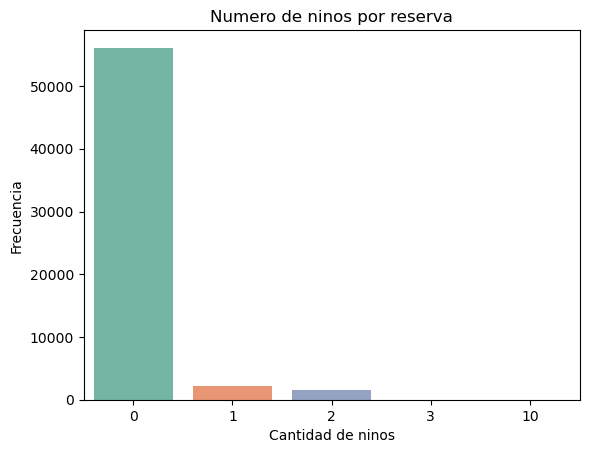

In [45]:
eje_y = hotelsdf["children_num"].value_counts()
eje_x = eje_y.index.tolist()
sns.barplot(y = eje_y, x = eje_x, palette='Set2')
plt.xlabel('Cantidad de ninos')
plt.ylabel(ylabel='Frecuencia')
plt.title('Numero de ninos por reserva')

hotelsdf["children_num"].value_counts()

Vemos que la gran mayoria de las reservas fueron hechas con 0 niños.\
Unos menos con 1 y 2; e incluso menos con 3. \
Sin embargo, nos figura una fila que reservo con 10 niños. Dicha fila es la siguiente:

In [46]:
hotelsdf[hotelsdf["children_num"] == 10]

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
49181,Resort Hotel,55,2015,July,29,12,4,10,2,10,...,NaN,0,Contract,133.16,0,1,No-Show,2015-07-12,44093355-c1c8-41eb-bcb4-40dc494fa1a9,1


#### Ajustes de valor



Considerando que es un valor tanto mas alto que el resto, que es un unico caso y considerando que fue hecha con **2 adultos** nada mas; podemos considerar que este outlier y que lo podemos remover. 

In [47]:
hotelsdf.drop((hotelsdf[hotelsdf["children_num"] == 10].index.values),inplace=True)
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,NaN,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,NaN,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,NaN,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,NaN,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,NaN,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59911,Resort Hotel,24,2017,January,4,27,0,2,2,0,...,NaN,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1
59912,City Hotel,0,2016,September,36,2,0,1,1,0,...,NaN,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0
59913,City Hotel,10,2017,May,19,8,1,2,1,0,...,153.0,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0
59914,Resort Hotel,143,2015,October,41,10,2,5,2,0,...,NaN,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1


Una vez ajustados los valores, nuestros valores toman la siguiente forma:

0    56110
1     2262
2     1523
3       21
Name: children_num, dtype: int64

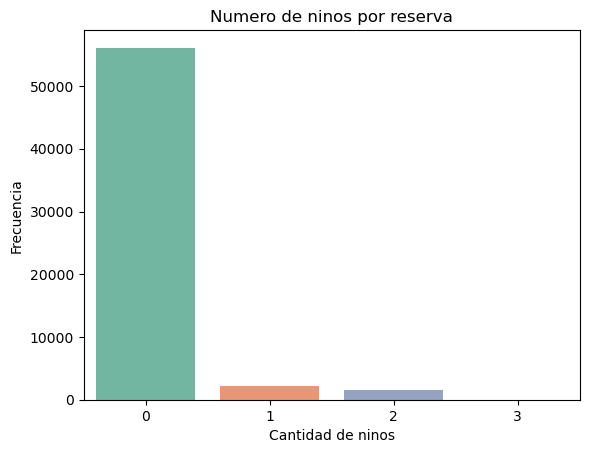

In [48]:
eje_y = hotelsdf["children_num"].value_counts()
eje_x = eje_y.index.tolist()
sns.barplot(y = eje_y, x = eje_x, palette='Set2')
plt.xlabel('Cantidad de ninos')
plt.ylabel(ylabel='Frecuencia')
plt.title('Numero de ninos por reserva')

hotelsdf["children_num"].value_counts()

### days in the waiting list 

#### Valores estadisticos relevantes

In [49]:
hotelsdf["days_in_waiting_list"].describe()

count    59916.000000
mean         2.703485
std         18.858684
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        391.000000
Name: days_in_waiting_list, dtype: float64

Days in waiting list representa la cantidad de dias que la reserva estuvo en la lista de espera antes de serconfirmada.
Esta variable es **discreta**, porque representa una cantidad discreta de dias.\
Esta esta alamacenada como int:

In [50]:
print(hotelsdf["days_in_waiting_list"].dtype)

int64


#### Valores nulos/faltantes

In [51]:
hotelsdf.days_in_waiting_list.isna().sum()

0

No tiene valores vacios

#### Grafica de distribución

In [52]:
print("Los valores que toma la variable son los siguientes:")
daysInWaitingListValores = (hotelsdf["days_in_waiting_list"].unique())
daysInWaitingListValores.sort()
print(daysInWaitingListValores)
print()
print("Y toma dichos valores con la siguiente frecuencia")
hotelsdf["days_in_waiting_list"].value_counts()

Los valores que toma la variable son los siguientes:
[  0   1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18
  19  20  21  22  24  25  26  27  28  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  53  54  55  56  57  58
  59  60  61  62  63  64  65  68  69  70  71  73  75  76  77  79  80  81
  83  84  85  87  89  91  93  96  98  99 100 101 105 107 108 109 111 113
 117 120 121 122 125 142 147 150 160 162 174 175 176 178 187 193 207 215
 223 224 236 259 330 379 391]

Y toma dichos valores con la siguiente frecuencia


0      57699
39       155
31        90
44        83
58        82
       ...  
54         1
81         1
121        1
193        1
105        1
Name: days_in_waiting_list, Length: 115, dtype: int64

Observamos que la gran mayoria de la gente estuvo 0 dias en la lista de espera. 

Vamos a graficar los valores mayores a 0 para poder apreciar la distribución de los otros datos

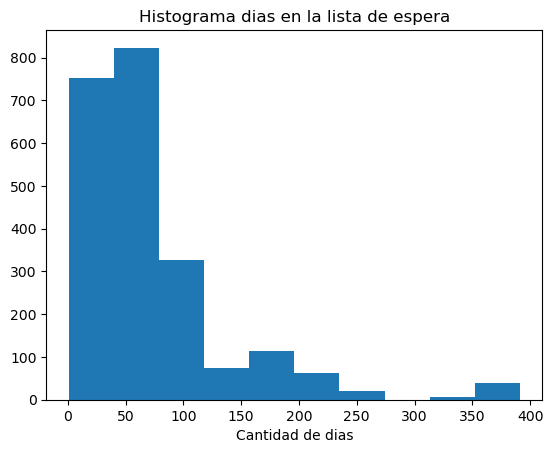

In [53]:
mayor0=hotelsdf[hotelsdf["days_in_waiting_list"] > 0]
mayor0.reset_index(drop=True)
plt.hist(mayor0.days_in_waiting_list)
plt.title('Histograma dias en la lista de espera')
plt.xlabel('Cantidad de dias')
plt.show()

Vamos a trazar un boxplot para tratar de identificar valores outliers

Text(0, 0.5, 'Dias')

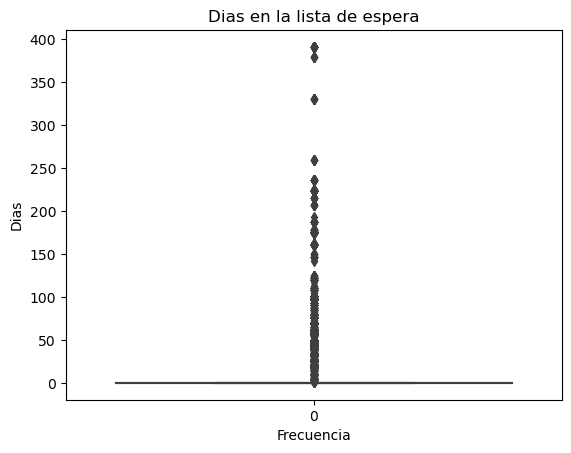

In [54]:
sns.boxplot(data = hotelsdf['days_in_waiting_list'])
plt.title("Dias en la lista de espera")
plt.xlabel('Frecuencia')
plt.ylabel('Dias')

La forma de este grafico nos muestra que tenemos muchos casos de 1 sola ocurrencia para todos los valores que no son 0.
Sin embargo esos valores representan un:

In [55]:
print(str((len(mayor0)*100)/len(hotelsdf)) + "%")

3.7001802523532947%


Vale casi un 4% del tota. Consideramos un tanto elevado para eliminarlos 

### lead time 

#### Valores estadisticos relevantes

In [56]:
hotelsdf["lead_time"].describe()

count    59916.000000
mean       113.737466
std        111.083474
min          0.000000
25%         24.000000
50%         80.000000
75%        173.000000
max        629.000000
Name: lead_time, dtype: float64

Lead time representa la cantidad de dias que hubo entre el dia que se realizo la reserva y el dia de llegada.\
Esta variable es **discreta**, porque representa una cantidad discreta de dias.\
Esta esta alamacenada como int:

In [57]:
print(hotelsdf["lead_time"].dtype)

int64


#### Valores nulos/faltantes

In [58]:
hotelsdf.days_in_waiting_list.isna().sum()

0

No tiene valores faltantes

#### Grafica de distribución

Vamos a analizar la frecuencia de los distintos valores que lead time puede tomar

In [59]:
print("Los valores que toma la variable son los siguientes:")
daysInWaitingListValores = (hotelsdf["lead_time"].unique())
daysInWaitingListValores.sort()
print(daysInWaitingListValores)
print()
print("Y toma dichos valores con la siguiente frecuencia")
hotelsdf["lead_time"].value_counts()

Los valores que toma la variable son los siguientes:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 23

0      2476
1      1419
2       851
3       755
4       742
       ... 
371       1
375       1
399       1
380       1
400       1
Name: lead_time, Length: 472, dtype: int64

Vamos a graficarlos para ver su distribución

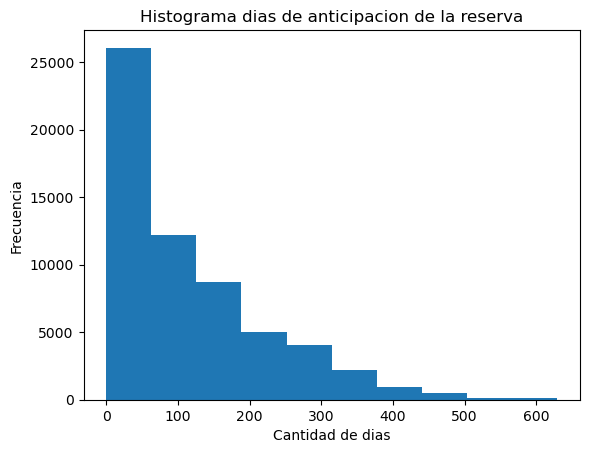

In [60]:
plt.hist(hotelsdf.lead_time)
plt.title('Histograma dias de anticipacion de la reserva')
plt.xlabel('Cantidad de dias')
plt.ylabel('Frecuencia')
plt.show()

Vemos que la mayoria de los valores estan por debajo de 300

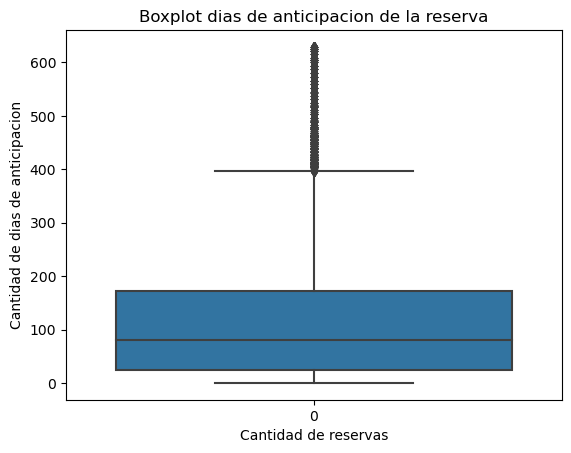

In [61]:
sns.boxplot(data=hotelsdf.lead_time)
plt.xlabel("Cantidad de reservas")
plt.ylabel("Cantidad de dias de anticipacion")
plt.title("Boxplot dias de anticipacion de la reserva")
plt.show()

In [62]:
hotelsdf[hotelsdf["lead_time"] >= 400]

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
15,City Hotel,465,2017,July,30,26,0,3,2,0,...,NaN,0,Transient-Party,112.67,0,0,Canceled,2017-07-18,d73d9a15-bcb1-441e-9571-56cbdde0e670,1
51,City Hotel,489,2016,November,46,10,0,2,2,0,...,NaN,0,Transient,62.80,0,0,Canceled,2015-10-21,264b4bdc-1f93-41dc-bad8-381405061cb1,1
82,City Hotel,412,2016,August,35,25,0,2,2,0,...,NaN,0,Transient,62.00,0,0,Canceled,2015-10-21,29230190-f1d1-4d9e-90ec-d9d4a0755cfd,1
95,City Hotel,454,2016,October,41,6,0,2,2,0,...,NaN,0,Transient,62.00,0,0,Canceled,2015-10-21,11de0e85-b5c6-4876-96b7-37c65f479ec5,1
99,City Hotel,420,2016,September,36,3,2,2,2,0,...,NaN,0,Transient,75.00,0,0,Canceled,2015-10-12,14d571b1-1cf3-4058-b50a-46367cd4f47e,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61753,City Hotel,433,2016,September,37,8,0,3,2,0,...,NaN,0,Transient,70.00,0,0,Canceled,2015-10-20,29a08da1-e707-4bd4-bbfe-ca55c19b7c3b,1
61761,City Hotel,496,2016,November,47,17,0,2,2,0,...,NaN,0,Transient,62.80,0,0,Canceled,2015-10-21,159515de-2c06-41b2-8364-f34ddee5e1c6,1
61768,City Hotel,433,2016,September,38,15,0,2,2,0,...,NaN,0,Transient,62.00,0,0,Canceled,2015-10-21,6f8bfdd6-6c76-449c-8ef4-ba22b2ece17c,1
61783,City Hotel,454,2016,October,41,6,0,2,2,0,...,NaN,0,Transient,62.00,0,0,Canceled,2015-10-21,5e1faaa8-cf26-4e74-bc1f-0fbcbfe65c01,1


#### Outliers


In [63]:
porcentaje = str((len(hotelsdf[hotelsdf["lead_time"] >= 400]) * 100)/len(hotelsdf))
print("Los valores mas llamativos son aquellos por encima de 400. Dichos valores representan un: " + porcentaje + "%")

Los valores mas llamativos son aquellos por encima de 400. Dichos valores representan un: 2.141331197009146%


Es un porcentaje lo suficientemente bajo para poder borrarlos

In [64]:
hotelsdf.drop(hotelsdf[hotelsdf["lead_time"] >= 400].index, inplace = True)
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,NaN,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,NaN,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,NaN,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,NaN,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,NaN,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58628,Resort Hotel,24,2017,January,4,27,0,2,2,0,...,NaN,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1
58629,City Hotel,0,2016,September,36,2,0,1,1,0,...,NaN,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0
58630,City Hotel,10,2017,May,19,8,1,2,1,0,...,153.0,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0
58631,Resort Hotel,143,2015,October,41,10,2,5,2,0,...,NaN,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1


Vamos a observar como se ve nuestro grafico despues de sacar los outliers

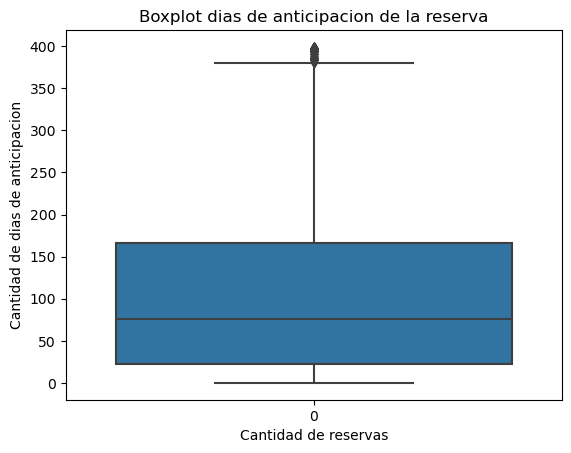

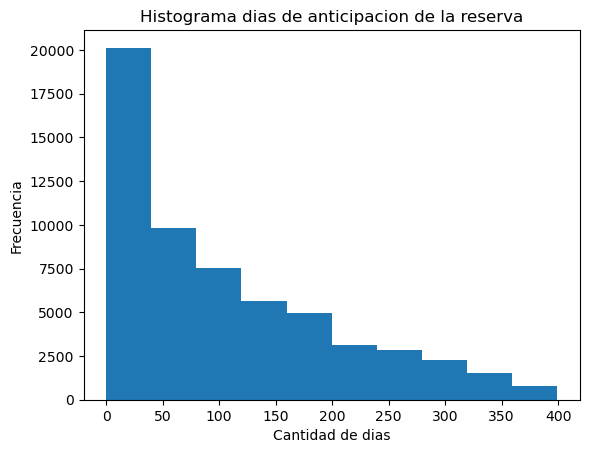

In [65]:
sns.boxplot(data=hotelsdf.lead_time)
plt.xlabel("Cantidad de reservas")
plt.ylabel("Cantidad de dias de anticipacion")
plt.title("Boxplot dias de anticipacion de la reserva")
plt.show()

plt.hist(hotelsdf.lead_time)
plt.title('Histograma dias de anticipacion de la reserva')
plt.xlabel('Cantidad de dias')
plt.ylabel('Frecuencia')
plt.show()

### previous booking not cancelled number

#### Valores estadisticos relevantes

In [66]:
hotelsdf["previous_bookings_not_canceled_num"].describe()

count    58633.000000
mean         0.109733
std          1.387391
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         70.000000
Name: previous_bookings_not_canceled_num, dtype: float64

Esta variable representa la cantidad de reservasa que no fueron canceladas por el usuario antes de la reserva actual

#### Valores nulos/faltantes

In [67]:
hotelsdf.previous_bookings_not_canceled_num.isna().sum()

0

#### Grafica de distribución


In [68]:
print("Los valores que toma la variable son los siguientes:")
daysInWaitingListValores = (hotelsdf["previous_bookings_not_canceled_num"].unique())
daysInWaitingListValores.sort()
print(daysInWaitingListValores)
print()
print("Y toma dichos valores con la siguiente frecuencia")
hotelsdf["previous_bookings_not_canceled_num"].value_counts()

Los valores que toma la variable son los siguientes:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 36 38 40 41 43 49 50 55 56 58 59 61 62 63
 64 69 70]

Y toma dichos valores con la siguiente frecuencia


0     57246
1       569
2       236
3       139
4        97
5        71
6        36
8        28
7        27
10       20
9        20
11       18
13       15
12       13
14       10
25       10
15        7
18        7
24        6
26        5
17        5
28        4
22        4
19        3
27        3
21        3
20        3
16        2
58        2
29        2
23        2
49        1
56        1
32        1
63        1
36        1
59        1
69        1
31        1
43        1
50        1
41        1
40        1
61        1
55        1
33        1
70        1
38        1
30        1
62        1
64        1
Name: previous_bookings_not_canceled_num, dtype: int64

Vamos a graficar los valores mayores a 0 para poder apreciar la distribución de los otros datos

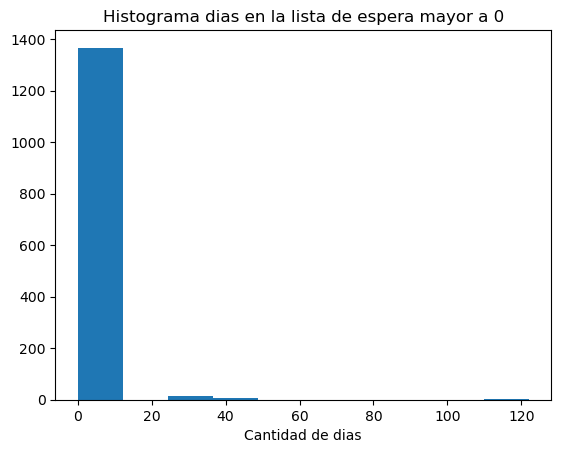

In [69]:
mayor0=hotelsdf[hotelsdf["previous_bookings_not_canceled_num"] > 0]
mayor0.reset_index(drop=True)
plt.hist(mayor0.days_in_waiting_list)
plt.title('Histograma dias en la lista de espera mayor a 0')
plt.xlabel('Cantidad de dias')
plt.show()

Del grafico se observa que la gran mayoria de la gente que no cancelo, no cancelaron entre 1 y 10 veces

#### Outliers

Text(0, 0.5, 'Dias')

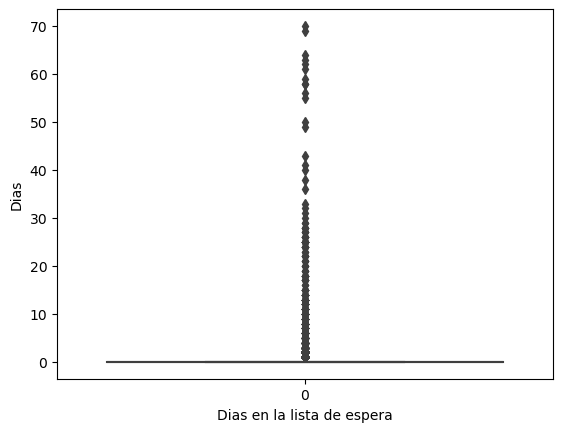

In [70]:
sns.boxplot(data = hotelsdf['previous_bookings_not_canceled_num'])
plt.xlabel('Dias en la lista de espera')
plt.ylabel('Dias')

Debido a la gran cantidad de valores con 0, y a la poca cantidad de valores sin 0 todos los valores distintos a 0 figuran como outliers. \
Dichos valores representan:

In [71]:
print(str((len(hotelsdf[hotelsdf["previous_bookings_not_canceled_num"] > 0])*100)/len(hotelsdf)) + "%")

2.365562055497757%


Considerando el bajo volumen que representan, decidimos dropearlos

In [72]:
hotelsdf.drop(hotelsdf[hotelsdf["previous_bookings_not_canceled_num"] > 0].index, inplace = True)
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,NaN,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,NaN,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,NaN,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,NaN,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,NaN,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57241,Resort Hotel,24,2017,January,4,27,0,2,2,0,...,NaN,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1
57242,City Hotel,0,2016,September,36,2,0,1,1,0,...,NaN,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0
57243,City Hotel,10,2017,May,19,8,1,2,1,0,...,153.0,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0
57244,Resort Hotel,143,2015,October,41,10,2,5,2,0,...,NaN,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1


Sin embargo, al dropearlos, el resto de nuestros valores son 0. Esto quiere decir que todo el resto de las columnas presentan los mismos valores. \
Es por esto que decidimos eliminar la totalidad de la columna visto a que no nos aporta informacion.

In [73]:
hotelsdf.drop("previous_bookings_not_canceled_num", axis=1, inplace=True)
cuantitativas.remove("previous_bookings_not_canceled_num")
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,NaN,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,NaN,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,NaN,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,NaN,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,NaN,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57241,Resort Hotel,24,2017,January,4,27,0,2,2,0,...,NaN,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1
57242,City Hotel,0,2016,September,36,2,0,1,1,0,...,NaN,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0
57243,City Hotel,10,2017,May,19,8,1,2,1,0,...,153.0,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0
57244,Resort Hotel,143,2015,October,41,10,2,5,2,0,...,NaN,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1


### previous booking cancellation number

#### Valores estadisticos relevantes

In [74]:
hotelsdf["previous_cancellations_num"].describe()

count    57246.000000
mean         0.101387
std          0.897503
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         26.000000
Name: previous_cancellations_num, dtype: float64

Esta variable representa la cantidad de reservasa que si fueron canceladas por el usuario antes de la reserva actual

#### Valores nulos/faltantes

In [75]:
hotelsdf.previous_cancellations_num.isna().sum()

0

#### Grafica de distribución

In [76]:
print("Los valores que toma la variable son los siguientes:")
daysInWaitingListValores = (hotelsdf["previous_cancellations_num"].unique())
daysInWaitingListValores.sort()
print(daysInWaitingListValores)
print()
print("Y toma dichos valores con la siguiente frecuencia")
hotelsdf["previous_cancellations_num"].value_counts()

Los valores que toma la variable son los siguientes:
[ 0  1  2  3  6 11 14 19 21 24 25 26]

Y toma dichos valores con la siguiente frecuencia


0     53274
1      3860
26       20
19       17
24       17
25       16
2        16
14       12
3         7
11        3
6         3
21        1
Name: previous_cancellations_num, dtype: int64

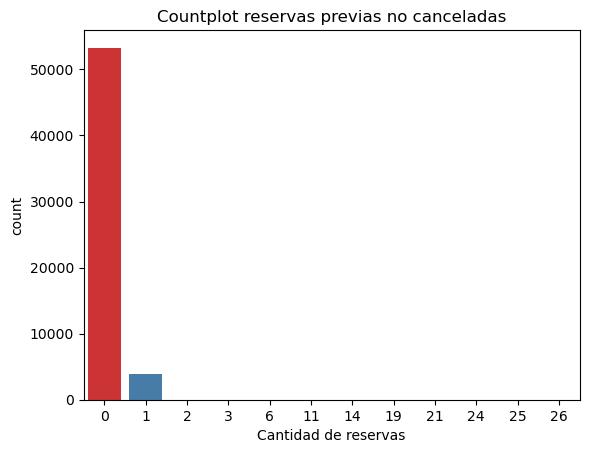

In [77]:
sns.countplot(data = hotelsdf, x='previous_cancellations_num', palette='Set1')
plt.title('Countplot reservas previas no canceladas')
plt.xlabel('Cantidad de reservas')
plt.show()

Del grafico y la distribución previa se observa que la gran mayoria de la gente que cancelo, cancelo 1 vez.

#### Outliers

Text(0, 0.5, 'Dias')

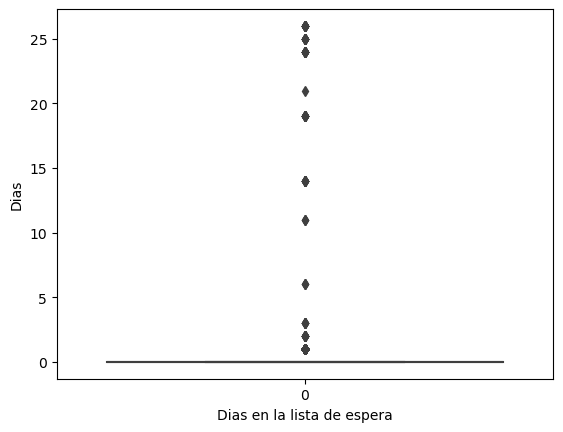

In [78]:
sns.boxplot(data = hotelsdf['previous_cancellations_num'])
plt.xlabel('Dias en la lista de espera')
plt.ylabel('Dias')

Del grafico se ve que todos los valores por encima de 0 estan  por fuera de los cuartiles.\
Sin embargo, esos datos representan:

In [79]:
print(str((len(hotelsdf[hotelsdf["previous_cancellations_num"] > 0])*100)/len(hotelsdf)) + "%")

6.938476050728435%


Porcentaje que es demasiado elevado como para eliminar

Sin embargo, la mayoria de estos datos estan concetrados en los registros con 1 cancelacion. Si tomamos un umbral un poco mayor podemos descartar los valores atipicos. Por ejemplo, los registros con 2 cancelaciones o mas represenan un

In [80]:
print(str((len(hotelsdf[hotelsdf["previous_cancellations_num"] >= 2])*100)/len(hotelsdf)) + "%")

0.19564685742235266%


Al ser un porcentaje tan insignificante, decidimos eliminar esas

In [81]:
hotelsdf.drop(hotelsdf[hotelsdf["previous_cancellations_num"] >= 2].index, inplace = True)
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,NaN,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,NaN,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,NaN,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,NaN,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,NaN,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57129,Resort Hotel,24,2017,January,4,27,0,2,2,0,...,NaN,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1
57130,City Hotel,0,2016,September,36,2,0,1,1,0,...,NaN,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0
57131,City Hotel,10,2017,May,19,8,1,2,1,0,...,153.0,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0
57132,Resort Hotel,143,2015,October,41,10,2,5,2,0,...,NaN,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1


Observamos como nuestros valores cambiaron despues del ajuste

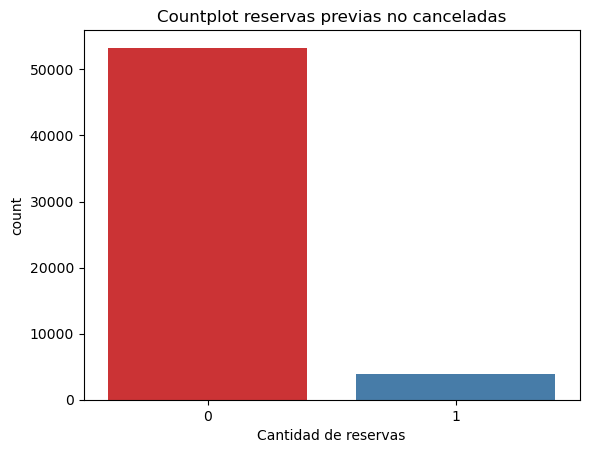

In [82]:
sns.countplot(data = hotelsdf, x='previous_cancellations_num', palette='Set1')
plt.title('Countplot reservas previas no canceladas')
plt.xlabel('Cantidad de reservas')
plt.show()

#### Ajustes de valor

### required car space number 

#### Valores estadisticos relevantes

In [83]:
hotelsdf.required_car_parking_spaces_num.describe()

count    57134.000000
mean         0.046102
std          0.210790
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: required_car_parking_spaces_num, dtype: float64

#### Valores nulos/faltantes

In [84]:
print("La cantidad de valores nulos/faltantes es", hotelsdf.required_car_parking_spaces_num.isna().sum())

La cantidad de valores nulos/faltantes es 0


#### Grafica de distribución

Text(0.5, 0, 'Espacios de autos requeridos')

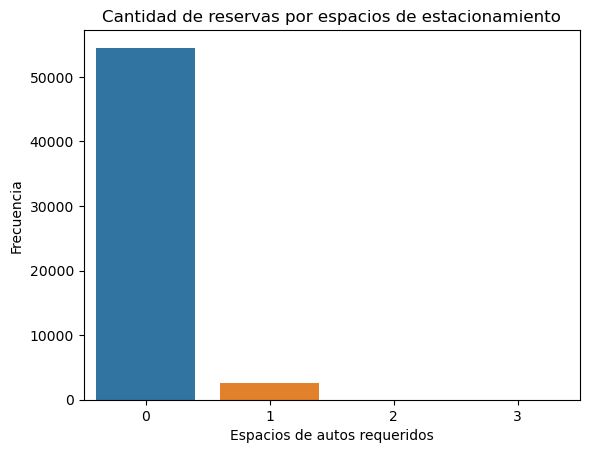

In [85]:
sns.countplot(data = hotelsdf, x='required_car_parking_spaces_num')
plt.title("Cantidad de reservas por espacios de estacionamiento")
plt.ylabel("Frecuencia")
plt.xlabel("Espacios de autos requeridos")

#### Outliers

Viendo el grafico podemos identificar que el numero de espacios de estacionamiento mas comun es 0, seguido por 1. 
Además encontramos algunos pocos casos en los que se reservaron 2, 3 y 8 espacios.
Estos ultimos son posibles Outliers.

Mostramos dichos registros junto con la columnas de adult_num para analizarlos más en detalle y determinar si alguno de ellos puede ser Outlier y por que.
Nuestro criterio para determinar que un valor es adecuado para esta variable es que haya como mucho 1 espacio de estacionamiento por adulto en la reserva.

In [86]:
registrosDosOMasEspacios = hotelsdf[hotelsdf["required_car_parking_spaces_num"]>=2]
display(registrosDosOMasEspacios[['adult_num', "required_car_parking_spaces_num"]].sort_values(
    by = "required_car_parking_spaces_num", 
    ascending = False
))

,adult_num,required_car_parking_spaces_num
13713,2,3
2168,2,2
11056,2,2
11820,2,2
14389,3,2
22088,2,2
38632,2,2
42628,2,2
51270,2,2
53941,2,2


De la tabla anterior se pueden sacar las siguientes conclusiones:
- El resgistro con valor de 8 espacios de estacionamiento es claramente un Outlier ya que no es coherente que una habitacion para dos personas haya reservado esa cantidad de espacios de estacionamiento.
- El resgistro con el valor de 3 espacios de estacionamiento y 2 adultos tambien es un Outliers ya que tampoco es coherente que 2 personas hayan reservado 3 espacios de estacionamiento.
- Los registros restantes NO son Outliers ya que si bien contienen valores poco freciuentes, son coherentes con el criterio explicado en el parrafo de arriba.

#### Ajustes de valor

Con el analisis anteior, tomamos las siguiuentes decisiones:
- Para el resgistro con valor de 8 espacios de estacionamiento,lo eliminamos por tratarse de un Outlier muy grosero.
- En el registro resgistro con el valor de 3 espacios de estacionamiento y 2 adultos, cambiamos el valor de required_car_parking_spaces_num por el valor "2" suponiendo un error de tipeo.
- Se mantienen sin cambios el resto de los registros restantes listados arriba.

In [87]:
hotelsdf.loc[ (hotelsdf.required_car_parking_spaces_num==3) & (hotelsdf.adult_num==2) , "required_car_parking_spaces_num"] = 2

Text(0.5, 0, 'Espacios de autos requeridos')

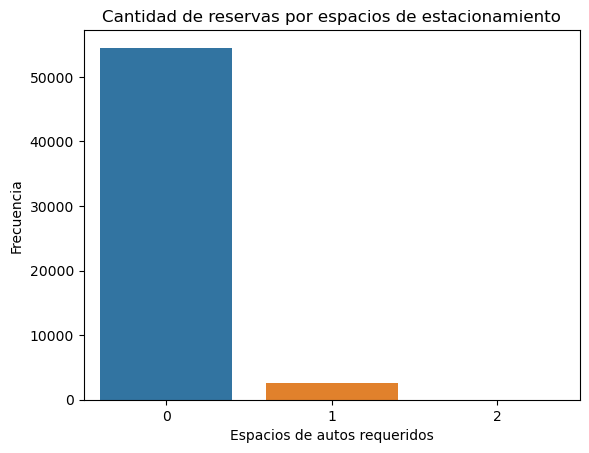

In [88]:
sns.countplot(data = hotelsdf, x='required_car_parking_spaces_num')
plt.title("Cantidad de reservas por espacios de estacionamiento")
plt.ylabel("Frecuencia")
plt.xlabel("Espacios de autos requeridos")

### special requests number 

#### Valores estadisticos relevantes

In [89]:
hotelsdf.special_requests_num.describe() 

count    57134.000000
mean         0.523909
std          0.770758
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: special_requests_num, dtype: float64

#### Valores nulos/faltanteS

In [90]:
print("La cantidad de valores nulos/faltantes es", hotelsdf.special_requests_num.isna().sum())

La cantidad de valores nulos/faltantes es 0


#### Grafica de distribución

Text(0, 0.5, 'Frecuencia')

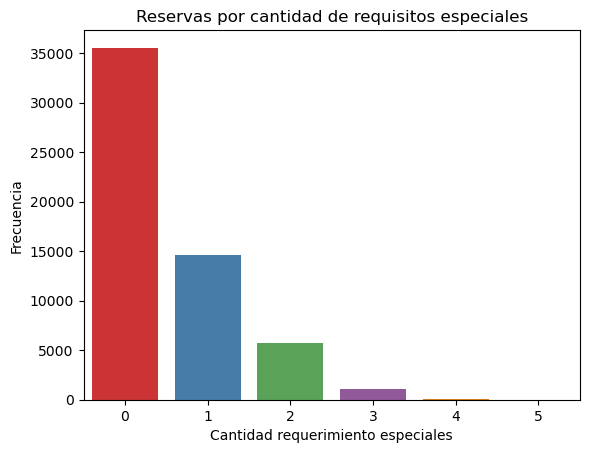

In [91]:
sns.countplot(data = hotelsdf, x='special_requests_num', palette='Set1')
plt.title("Reservas por cantidad de requisitos especiales")
plt.xlabel("Cantidad requerimiento especiales")
plt.ylabel("Frecuencia")

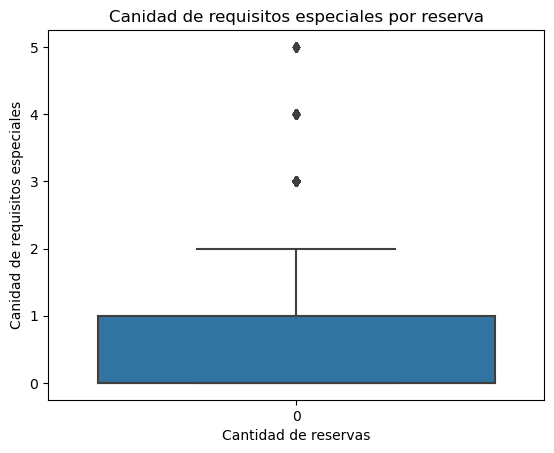

In [92]:
sns.boxplot(data=hotelsdf.special_requests_num)
plt.xlabel("Cantidad de reservas")
plt.ylabel("Canidad de requisitos especiales")
plt.title("Canidad de requisitos especiales por reserva")
plt.show()

#### Outliers

Viendo los graficos vemos que los valores mas frecuentes de requisitos especiales son 0 (ninguno), 1 y 2 y algunos menos con 3. Ademas hay muy pocos con 4 y 5. 
Los valores que podrian levantar sosppecha son 4 y 5.
Miramos la cantidad de registros de cada uno de ellos para ver que no sean casos puntuales.

In [93]:
print("hay", hotelsdf[hotelsdf.special_requests_num==4].shape[0] ,"reservas con 4 requisitos especiales")
print("hay", hotelsdf[hotelsdf.special_requests_num==5].shape[0] ,"reservas con 5 requisitos especiales")

hay 112 reservas con 4 requisitos especiales
hay 17 reservas con 5 requisitos especiales


#### Ajustes de valor

Debido a la la cantidad de reservas para estos casos y que el rango de valores es relativamente acotado, no parcen ser casos puntuales. 
Procedemos a cambiar la cantidad de requisitos especiales de dichos registros el valor mas frecuente

In [94]:
media_special_requests = round(hotelsdf.special_requests_num.mean())
hotelsdf.loc[hotelsdf['special_requests_num'] >= 4, 'special_requests_num'] = media_special_requests

Graficamos nuevamente la distribución de la variable para validar los cambios realizados 

Text(0, 0.5, 'Frecuencia')

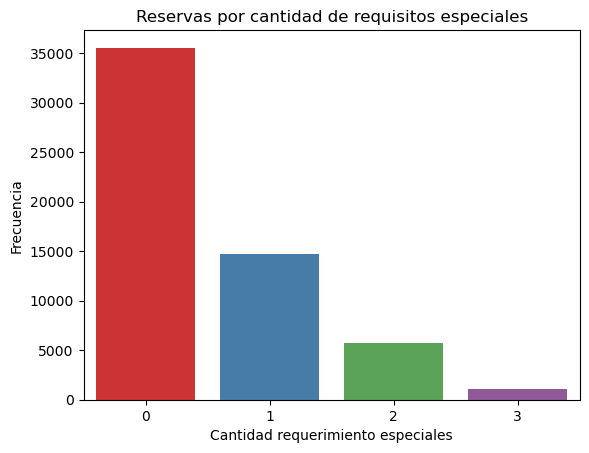

In [95]:
sns.countplot(data = hotelsdf, x='special_requests_num', palette='Set1')
plt.title("Reservas por cantidad de requisitos especiales")
plt.xlabel("Cantidad requerimiento especiales")
plt.ylabel("Frecuencia")

### weekend nights number

#### Valores estadisticos relevantes

In [96]:
hotelsdf.weekend_nights_num.describe() 

count    57134.000000
mean         0.947404
std          0.995895
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         16.000000
Name: weekend_nights_num, dtype: float64

#### Valores nulos/faltantes

In [97]:
print("La cantidad de valores nulos/faltantes es", hotelsdf.weekend_nights_num.isna().sum())

La cantidad de valores nulos/faltantes es 0


#### Grafica de distribución

Text(0, 0.5, 'Frecuencia')

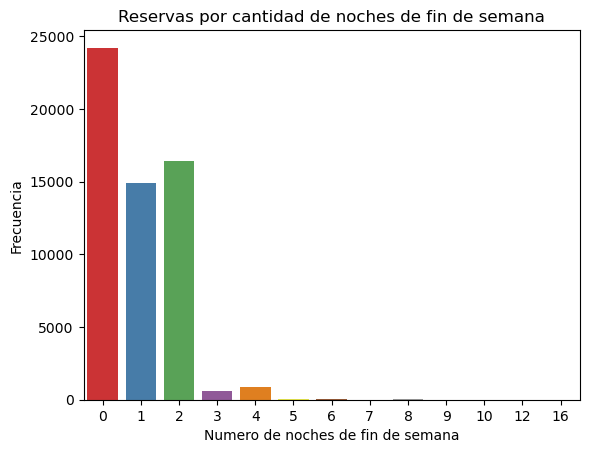

In [98]:
sns.countplot(data = hotelsdf, x='weekend_nights_num', palette='Set1')
plt.title("Reservas por cantidad de noches de fin de semana")
plt.xlabel("Numero de noches de fin de semana")
plt.ylabel("Frecuencia")

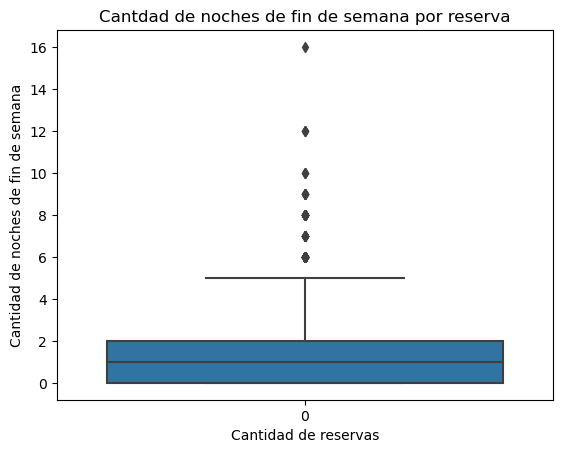

In [99]:
sns.boxplot(data=hotelsdf.weekend_nights_num)
plt.xlabel("Cantidad de reservas")
plt.ylabel("Cantidad de noches de fin de semana")
plt.title("Cantdad de noches de fin de semana por reserva")
plt.show()

#### Outliers

Podriamos suponer como posibles outliers, reservas con muchos dias de estadia. A simple vista se puede ver que hay pocas reservas con 5 o mas noches de fin de semana de estadia. Comenzamos estudiando los valores de 9 o mas dias de fin de semana ya que equivaldrian a un minimo de 4 semanas de estadia.

In [100]:
mayores_a_nueve = hotelsdf[hotelsdf["weekend_nights_num"]>=9]
mayores_a_nueve.shape[0]

13

Text(0, 0.5, 'Frecuencia')

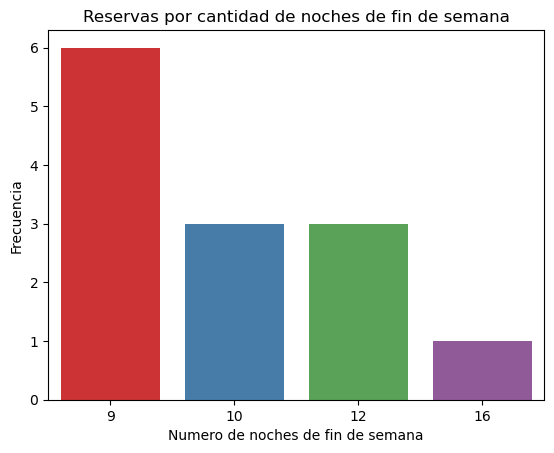

In [101]:
sns.countplot(data = mayores_a_nueve, x='weekend_nights_num', palette='Set1')
plt.title("Reservas por cantidad de noches de fin de semana")
plt.xlabel("Numero de noches de fin de semana")
plt.ylabel("Frecuencia")

#### Ajustes de valor

Son solo 13 registros, es decir, representan muy poca cantidad del total. Tomamos la decision de eliminarlos para evitar que generen ruido al momento de generar el modelo.

In [102]:
mas_de_nueve_noches_finde = hotelsdf[hotelsdf["weekend_nights_num"]>=9]
hotelsdf.drop(mas_de_nueve_noches_finde.index, inplace = True)
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,company_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,NaN,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,NaN,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,NaN,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,NaN,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,NaN,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57116,Resort Hotel,24,2017,January,4,27,0,2,2,0,...,NaN,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1
57117,City Hotel,0,2016,September,36,2,0,1,1,0,...,NaN,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0
57118,City Hotel,10,2017,May,19,8,1,2,1,0,...,153.0,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0
57119,Resort Hotel,143,2015,October,41,10,2,5,2,0,...,NaN,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1


Hasta ahora analizamos las estadias con mas de 9 noches de fin de semana (al menos un mes de esatdia)
Sin embargo nos resta estudiar, los casos de 5, 6, 7 y 8 dias de fin de semana.
Vemos cuantos registros son

In [103]:
mayores_a_5_menores_a_nueve_finde = hotelsdf[hotelsdf["weekend_nights_num"]>=5]
mayores_a_5_menores_a_nueve_finde.shape[0]

167

<AxesSubplot: xlabel='weekend_nights_num', ylabel='count'>

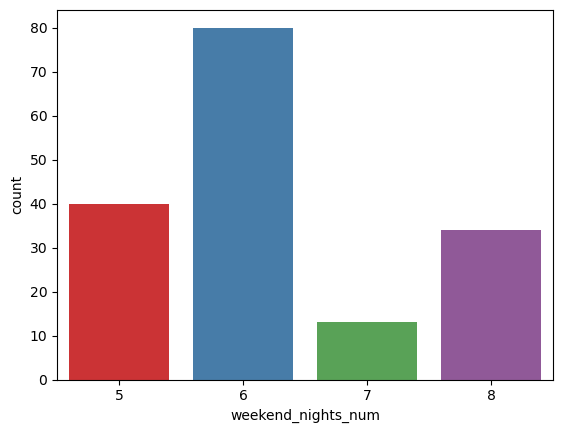

In [104]:
mayores_a_5_menores_a_nueve_finde = hotelsdf[hotelsdf["weekend_nights_num"]>=5]
sns.countplot(data = mayores_a_5_menores_a_nueve_finde, x='weekend_nights_num', palette='Set1')

Como son muchos mas registros posponemos su analisis para estudiarlos en un analisis multivariado despues de terminar de estudiar todas las variables cuantitativas pero los dejamos marcados como posibles registros a modificar.

Text(0, 0.5, 'Frecuencia')

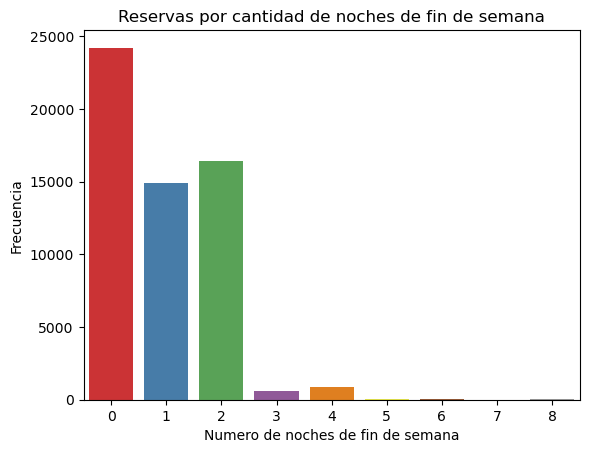

In [105]:
sns.countplot(data = hotelsdf, x='weekend_nights_num', palette='Set1')
plt.title("Reservas por cantidad de noches de fin de semana")
plt.xlabel("Numero de noches de fin de semana")
plt.ylabel("Frecuencia")

### week nights number 

#### Valores estadisticos relevantes

In [106]:
hotelsdf.week_nights_num.describe() 

count    57121.000000
mean         2.547907
std          1.858205
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         22.000000
Name: week_nights_num, dtype: float64

#### Valores nulos/faltantes

In [107]:
print("La cantidad de valores nulos/faltantes es", hotelsdf.week_nights_num.isna().sum())

La cantidad de valores nulos/faltantes es 0


#### Grafica de distribución

Text(0, 0.5, 'Frecuencia')

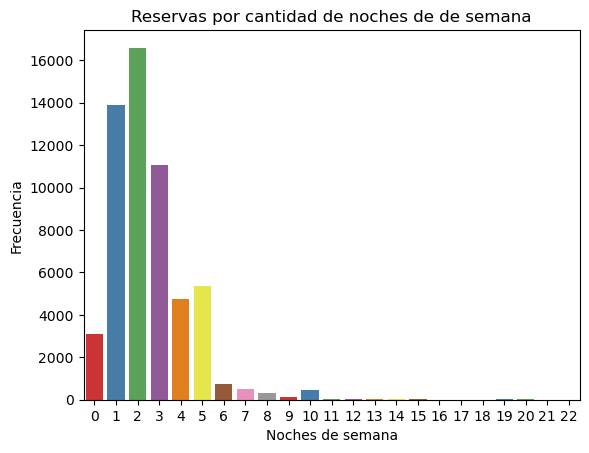

In [108]:
sns.countplot(data = hotelsdf, x='week_nights_num', palette='Set1')
plt.title("Reservas por cantidad de noches de de semana")
plt.xlabel("Noches de semana")
plt.ylabel("Frecuencia")

Se puede ver que la gran mayoria de las reservas son estadias de entre ningna (0) y 5 noches de semana y en menor medida estadias de entre 6 y 10 noches de semana. 
Como en el grafico no se ven puntualmente los registros con estadias de 11 o mas noches de semana, los graficamos de nuevo para ver como se distribuyen y estudiarlos mejor

In [109]:
mayores_a_11_noches_semana = hotelsdf[hotelsdf["week_nights_num"]>=11]
mayores_a_11_noches_semana.shape[0]

200

Text(0, 0.5, 'Frecuencia')

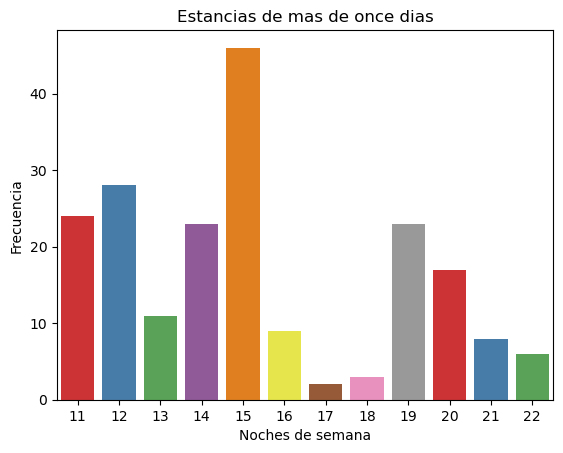

In [110]:
sns.countplot(data = mayores_a_11_noches_semana, x='week_nights_num', palette='Set1')
plt.title("Estancias de mas de once dias")
plt.xlabel("Noches de semana")
plt.ylabel("Frecuencia")

Como son muchos registros y no contienen valores incoherentes a primera vista posponemos su tratamiento para estudiarlos con un analisis multivariado comparandolo con weekend_nights_number en dicha seccion.

Ocurre que ademas los registros que este caso representarian una desviacion muy grande fueron eliminados al momento de eliminar aquellos outliers de noches de fin de semana

## Cualitativas

Variables cualitativas

En un principio establecemos una lista que contenga todas las variables cualitativas

In [111]:
cualitativas = [
"agent_id",
"arrival_month",
"assigned_room_type",
"booking_id",
"company_id",
"country",
"customer_type",
"deposit_type",
"distribution_channel",
"hotel_name",
'is_canceled',
"is_repeated_guest",
"market_segment_type",
"meal_type",
"reserved_room_type",
]

### Valores nulos

/tmp/ipykernel_19312/2120960639.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cuantitativas_nulas_per = pd.Series()


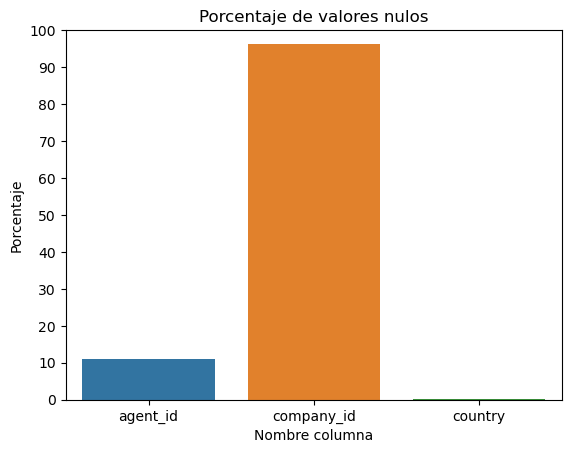

In [112]:
cualitativas_nulas = hotelsdf[cualitativas].isnull().sum()
cualitativas_nulas = cualitativas_nulas[cualitativas_nulas > 0]

cuantitativas_nulas_per = pd.Series()

for indice in cualitativas_nulas.index:
    cuantitativas_nulas_per[indice] = cualitativas_nulas[indice]/len(hotelsdf[indice])*100

sns.barplot(x = cuantitativas_nulas_per.index, y = cuantitativas_nulas_per)
plt.ylabel(ylabel= 'Porcentaje')
plt.xlabel(xlabel= 'Nombre columna')
plt.title(label = 'Porcentaje de valores nulos')
plt.ylim(0, 100)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

Viendo que la columna company_id tiene un 92% de valores faltantes es conveniente para el analisis eliminar la columna 

In [113]:
hotelsdf.drop("company_id", axis=1, inplace=True)
hotelsdf.reset_index(drop=True)
cualitativas.remove("company_id")

Por otro lado la variable booking ID no sera graficada puesto que corresponde a una cadena que representa un codigo unico para cada reserva 

### Agent ID

#### Valores que toma

In [114]:
agent_id_valores = (hotelsdf["agent_id"].unique())
agent_id_valores.sort()
print(agent_id_valores)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  44.
  45.  47.  50.  52.  53.  55.  56.  57.  58.  59.  60.  61.  63.  64.
  66.  67.  68.  69.  71.  72.  74.  75.  77.  78.  79.  81.  82.  83.
  85.  86.  87.  88.  89.  91.  92.  93.  94.  95.  96.  98.  99. 103.
 104. 105. 106. 107. 110. 111. 112. 114. 115. 118. 119. 121. 126. 127.
 128. 129. 132. 133. 134. 138. 139. 141. 142. 143. 144. 146. 147. 149.
 151. 152. 153. 154. 155. 156. 157. 159. 162. 163. 167. 168. 170. 171.
 173. 174. 175. 177. 179. 180. 181. 182. 183. 184. 185. 187. 191. 192.
 193. 195. 196. 197. 201. 205. 208. 210. 214. 215. 219. 220. 223. 227.
 229. 234. 235. 236. 240. 241. 242. 243. 244. 245. 247. 248. 249. 250.
 251. 252. 253. 254. 256. 257. 258. 261. 262. 265. 267. 269. 270. 273.
 275. 276. 278. 281. 283. 286. 287. 288. 289. 290. 291. 295. 296. 298.
 299. 

#### Ajuste de valores faltantes

Reemplazamos valores faltantes por 0 ya que no existe previamente y servira para regular los tipos de atos de la columna

In [115]:
hotelsdf.loc[hotelsdf['agent_id'].isnull(), 'agent_id'] = 0
hotelsdf[hotelsdf.agent_id.isnull()]
hotelsdf['agent_id'] = hotelsdf['agent_id'].astype(int)

#### Grafica de distribución

In [116]:
cantidad = len(hotelsdf['agent_id'].value_counts().index.tolist())
print(f"La cantidad de identificaciones de empresa es: {cantidad}")

La cantidad de identificaciones de empresa es: 293


Debido a que existen 295 id de empresas, graficamos un muestreo de los 10 ids mas frecuentes en el dataframe

Text(0, 0.5, 'Frecuencia')

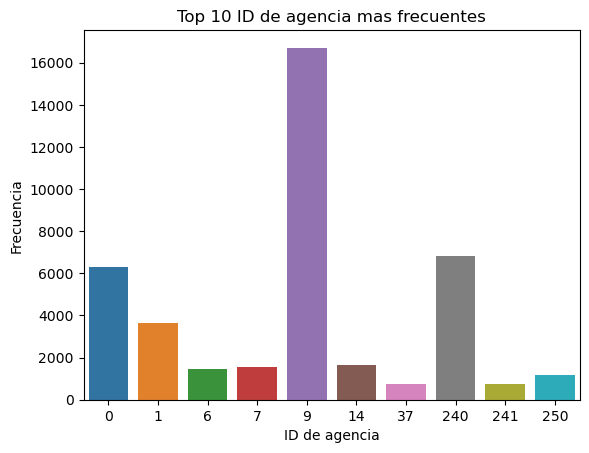

In [117]:
data = hotelsdf.agent_id.value_counts().sort_values(ascending=False).head(10)
sns.barplot(y = data, x = data.index.tolist())
plt.title('Top 10 ID de agencia mas frecuentes')
plt.xlabel('ID de agencia')
plt.ylabel('Frecuencia')

El resto de valores tienen representaciones de ids validas pero aparecen de manera menos frecuente, al ser tantos, mostramos los mas frecuentes para darnos una idea. En este caso el id mas frecuente es el 9 con aproximadamente unos 16 mil registros 

### arrival month

#### Valores que toma

In [118]:
arrival_month_valores = (hotelsdf["arrival_month"].unique())
month_lookup = list(month_name)
months = arrival_month_valores
sorted(months, key=month_lookup.index)

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

#### Grafica de la distribución

Text(0, 0.5, 'Frecuencia')

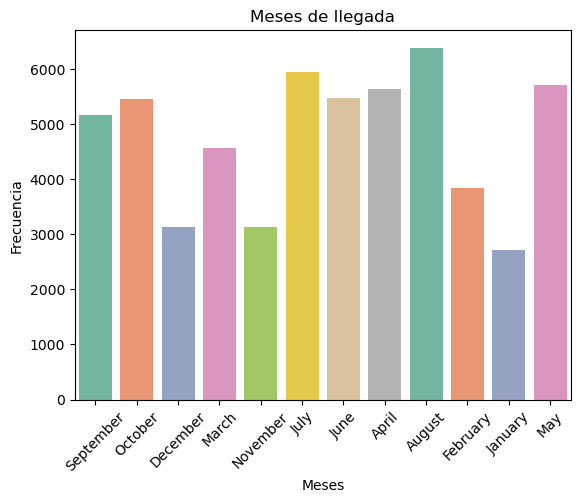

In [119]:
plt.title('Meses de llegada')
sns.countplot(data = hotelsdf, x = 'arrival_month', palette='Set2')
plt.xticks(rotation=45)
plt.xlabel('Meses')
plt.ylabel('Frecuencia')

Del siguiente grafico observamos que el mes de agosto es el mes con mas reservas hechas, por otro lado enero es el mes con menos reservas 

### Assigned Room type

### Valores que toma

In [120]:
assigned_room_type = hotelsdf['assigned_room_type'].unique().tolist()
ordenado = sorted(assigned_room_type)
print(ordenado) 

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K']


Realizamos un grafico de la frecuencia de los tipos de habitaciones asignadas 

#### Grafica de distribución

Text(0, 0.5, 'Frecuencia')

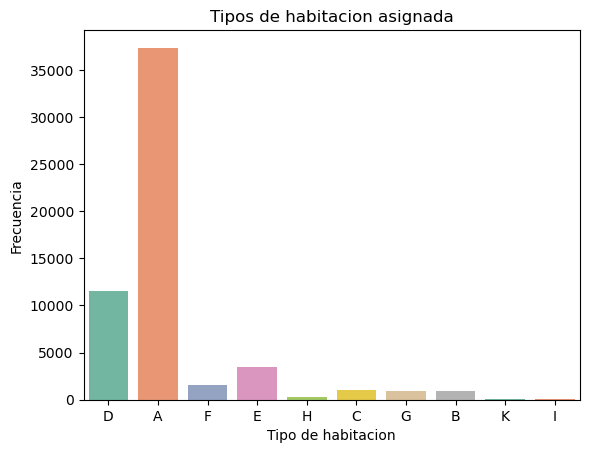

In [121]:
sns.countplot(data = hotelsdf, x='assigned_room_type', palette='Set2')
plt.title('Tipos de habitacion asignada')
plt.xlabel('Tipo de habitacion')
plt.ylabel('Frecuencia')

Del cual concluimos que las habitaciones de tipo: H, I y K son las menos frecuentas y la habitacion tipo A se lleva la mayoria de las apariciones en los registros 

### Country

#### Valores que toma

In [122]:
country = hotelsdf['country'].unique().tolist()
print(country) 

['USA', 'PRT', 'CHE', 'FRA', 'AGO', 'GBR', 'DEU', 'ESP', 'ROU', 'SWE', 'IRL', 'CN', 'ITA', 'NLD', 'NOR', 'MAR', 'BEL', 'ISR', 'KOR', 'IND', 'TUN', 'JPN', 'FIN', 'TUR', 'CHN', 'AUT', 'ZAF', 'LUX', 'BRA', 'POL', 'DNK', 'IRN', 'RUS', 'VEN', 'AUS', 'MLT', 'BGR', 'GEO', 'SRB', 'PHL', 'ARG', 'LVA', 'LTU', 'ARE', 'VNM', 'MOZ', nan, 'THA', 'MEX', 'HUN', 'DZA', 'GAB', 'UKR', 'SVN', 'HRV', 'SVK', 'CHL', 'BLR', 'CPV', 'CRI', 'EST', 'TWN', 'ALB', 'SGP', 'IDN', 'DOM', 'MUS', 'OMN', 'EGY', 'SAU', 'NZL', 'FRO', 'CYP', 'PER', 'CZE', 'GRC', 'ARM', 'COL', 'PAK', 'MDG', 'HKG', 'MYS', 'MKD', 'ISL', 'BIH', 'NGA', 'AZE', 'MAC', 'JEY', 'SUR', 'KWT', 'BGD', 'IRQ', 'MDV', 'GGY', 'VGB', 'ECU', 'URY', 'ETH', 'LBN', 'BOL', 'QAT', 'JOR', 'COM', 'GNB', 'UGA', 'BEN', 'GIB', 'SEN', 'TZA', 'LBY', 'SYC', 'PRY', 'MNE', 'ZWE', 'CAF', 'ATA', 'MWI', 'JAM', 'AND', 'LIE', 'FJI', 'PRI', 'TJK', 'LKA', 'KAZ', 'HND', 'PAN', 'CMR', 'KEN', 'UMI', 'MYT', 'PYF', 'GLP', 'BRB', 'CIV', 'ZMB', 'CUB', 'TGO', 'SYR', 'SDN', 'NAM', 'GHA', '

#### Grafica de distribución

Text(0, 0.5, 'Frecuencia')

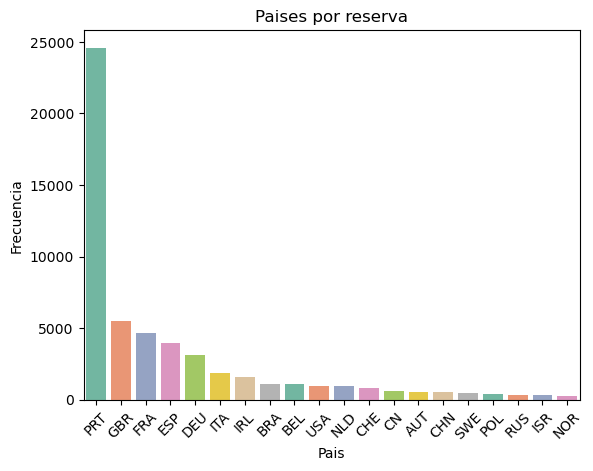

In [123]:
data = hotelsdf.country.value_counts().sort_values(ascending=False).head(20)
plt.xticks(rotation=45)
sns.barplot(y = data, x = data.index.tolist(), palette='Set2')
plt.title('Paises por reserva')
plt.xlabel('Pais')
plt.ylabel('Frecuencia')

Del grafico concluimos que Portugal es el pais del cual hay mayor numero de reservas, seguido de: Alemania, Fracia, España. Por otro lado aun hay registros con valores faltantes 

#### Valores faltantes

Para evitar la eliminacion de los registros y debido a la muy marcada tendencia de las reservas a venir de Portugal asignamos a los valores faltantes dicho pais, puesto que representas aproximadamente un 0.2% de los datos 

In [124]:
hotelsdf.loc[hotelsdf['country'].isnull(), 'country'] = 'PRT'

Dicha asignacion no genera una desviacion, la prueba de eso en el siguiente grafico 

Text(0, 0.5, 'Frecuencia')

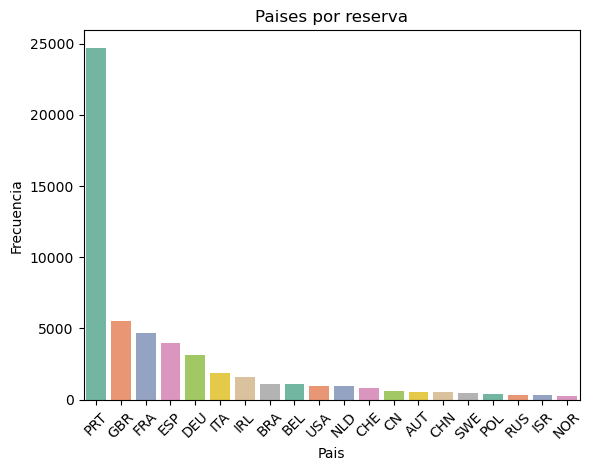

In [125]:
data = hotelsdf.country.value_counts().sort_values(ascending=False).head(20)
plt.xticks(rotation=45)
sns.barplot(y = data, x = data.index.tolist(), palette='Set2')
plt.title('Paises por reserva')
plt.xlabel('Pais')
plt.ylabel('Frecuencia')

### Customer type

#### Valores que toma

In [126]:
customer_typeValores = (hotelsdf["customer_type"].unique())
customer_typeValores.sort()
print(customer_typeValores)

['Contract' 'Group' 'Transient' 'Transient-Party']


#### Grafica de distribución

Text(0.5, 0, 'Tipo de cliente')

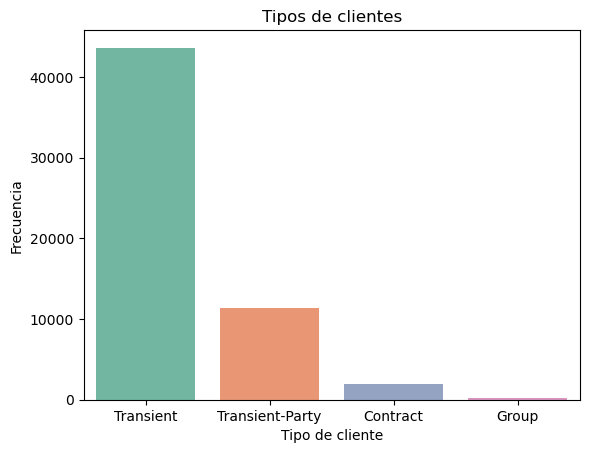

In [127]:
sns.countplot(data = hotelsdf, x = 'customer_type', palette='Set2')
plt.title("Tipos de clientes")
plt.ylabel("Frecuencia")
plt.xlabel("Tipo de cliente")

### Deposit type

#### Valores que toma

In [128]:
deposit_typeValores = (hotelsdf["deposit_type"].unique())
deposit_typeValores.sort()
print(deposit_typeValores)

['No Deposit' 'Non Refund' 'Refundable']


#### Grafica de distribución

Text(0.5, 0, 'Tipo de deposito')

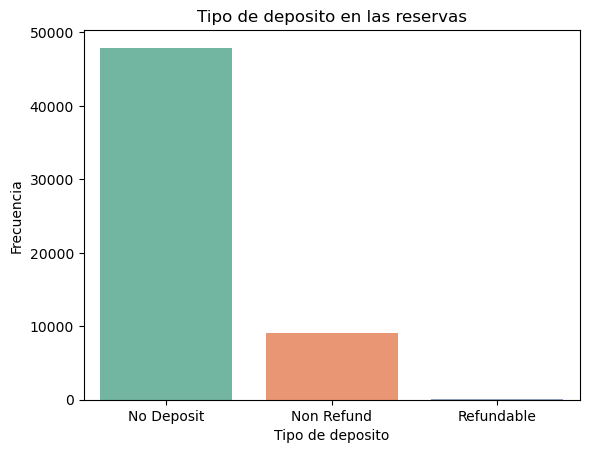

In [129]:
sns.countplot(data = hotelsdf, x = 'deposit_type', palette='Set2')
plt.title("Tipo de deposito en las reservas")
plt.ylabel("Frecuencia")
plt.xlabel("Tipo de deposito")

Del grafico apreciamos las frecuencias y los tipos de depositos disponibles en el dataframe, siendo No Deposit el mas frecuente y por el contrario Refundable se queda con la menor frecuencia

### Distribution channel

#### Valores que toma

In [130]:
distribution_channelValores = (hotelsdf["distribution_channel"].unique())
distribution_channelValores.sort()
print(distribution_channelValores)

['Corporate' 'Direct' 'GDS' 'TA/TO']


#### Grafica de distribución

Text(0, 0.5, 'Frecuencia')

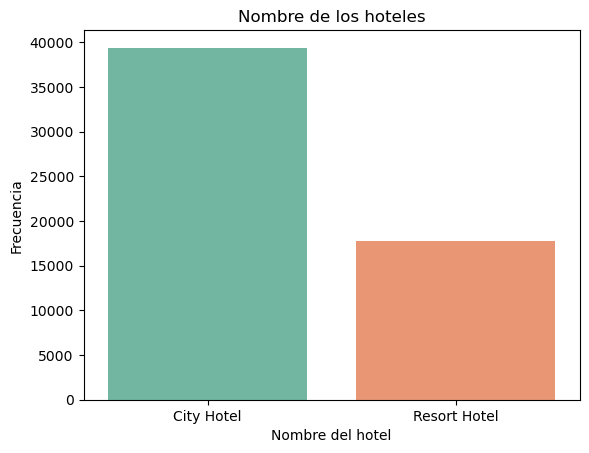

In [131]:
sns.countplot(data = hotelsdf, x = 'hotel_name', palette='Set2')
plt.title("Nombre de los hoteles")
plt.xlabel("Nombre del hotel")
plt.ylabel("Frecuencia")

Estudiamos la variable nombre de hotel, encontrando dos hoteles en el dataframe 

### Hotel Name

#### Valores que toma

In [132]:
hotel_nameValores = (hotelsdf["hotel_name"].unique())
hotel_nameValores.sort()
print(hotel_nameValores)

['City Hotel' 'Resort Hotel']


#### Grafica de distribución

Text(0, 0.5, 'Frecuencia')

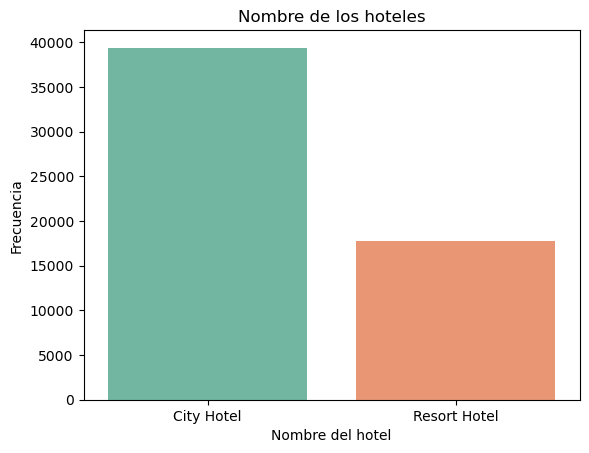

In [133]:
sns.countplot(data = hotelsdf, x = 'hotel_name', palette='Set2')
plt.title("Nombre de los hoteles")
plt.xlabel("Nombre del hotel")
plt.ylabel("Frecuencia")

Estudiamos la variable nombre de hotel, encontrando dos hoteles en el dataframe 

### Is canceled (Target)

#### Valores que toma

In [134]:
is_canceledValores = (hotelsdf["is_canceled"].unique())
is_canceledValores.sort()
print(is_canceledValores)

[0 1]


#### Grafica de distribución
La variable a predecir, dicha variable tiene valores 0 y 1, siendo 0 no cancelado y 1 las reservas canceladas

#### Grafica de distribución

Text(0.5, 0, 'Estado')

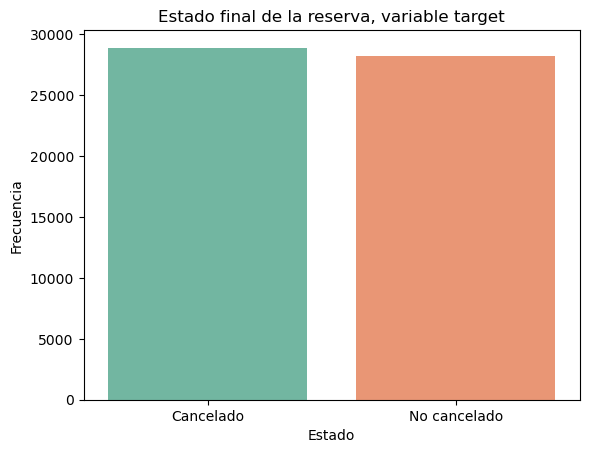

In [135]:
para_ver = pd.DataFrame()
para_ver['is_canceled'] = hotelsdf['is_canceled'].map({1: 'Cancelado', 0: 'No cancelado'})
sns.countplot(data = para_ver, x = 'is_canceled', palette='Set2')
plt.title('Estado final de la reserva, variable target')
plt.ylabel('Frecuencia')
plt.xlabel("Estado")

### Is repeated guest

#### Valores que toma


In [136]:
is_repeated_guestValores = (hotelsdf["is_repeated_guest"].unique())
is_repeated_guestValores.sort()
print(is_repeated_guestValores)

[0 1]


#### Grafica de distribución

Text(0.5, 0, 'Huesped repetido')

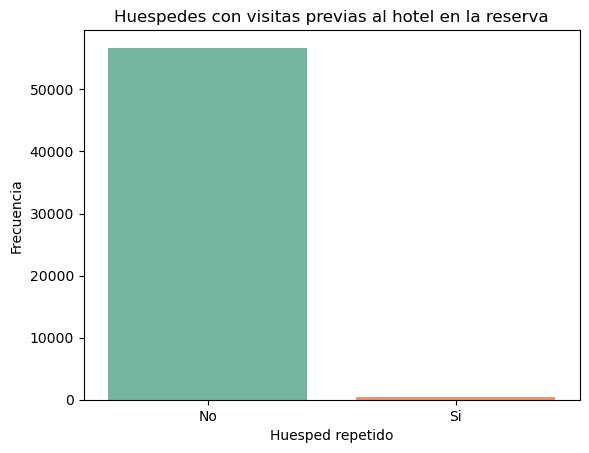

In [137]:
para_ver['is_repeated_guest'] = hotelsdf['is_repeated_guest'].map({1: 'Si', 0: 'No'})
sns.countplot(data = para_ver, x = 'is_repeated_guest', palette='Set2')
plt.title('Huespedes con visitas previas al hotel en la reserva')
plt.ylabel('Frecuencia')
plt.xlabel('Huesped repetido')

Del grafico es facil concluir que la mayoria de las reservas fueron realizados por usuarios que visitan por primera vez el hotel escogido


### Market segment

#### Valores que toma


In [138]:
market_segment_typeValores = (hotelsdf["market_segment_type"].unique())
market_segment_typeValores.sort()
print(market_segment_typeValores)

['Aviation' 'Complementary' 'Corporate' 'Direct' 'Groups' 'Offline TA/TO'
 'Online TA']


#### Grafica de distribución
#### Grafica de distribución

Text(0.5, 0, 'Segmento del mercado')

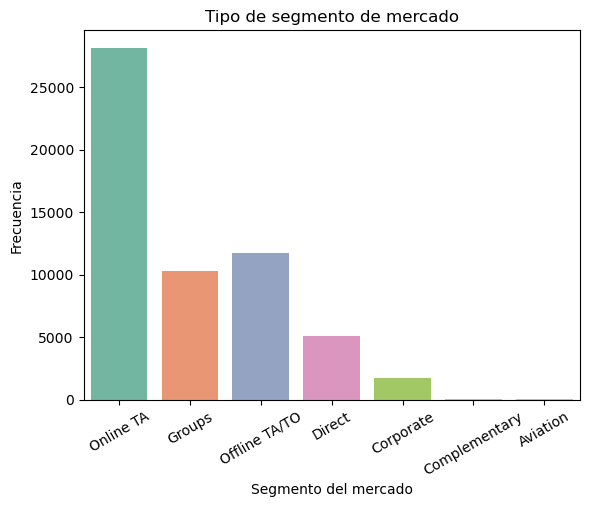

In [139]:
plt.xticks(rotation=30)
sns.countplot(data=hotelsdf, x = 'market_segment_type', palette='Set2')
plt.title("Tipo de segmento de mercado")
plt.ylabel("Frecuencia")
plt.xlabel("Segmento del mercado")

### meal type

#### Valores que toma

In [140]:
meal_typeValores = (hotelsdf["meal_type"].unique())
meal_typeValores.sort()
print(meal_typeValores)

['BB' 'FB' 'HB' 'SC' 'Undefined']


#### Grafica de distribución

Text(0.5, 0, 'Tipo de comida')

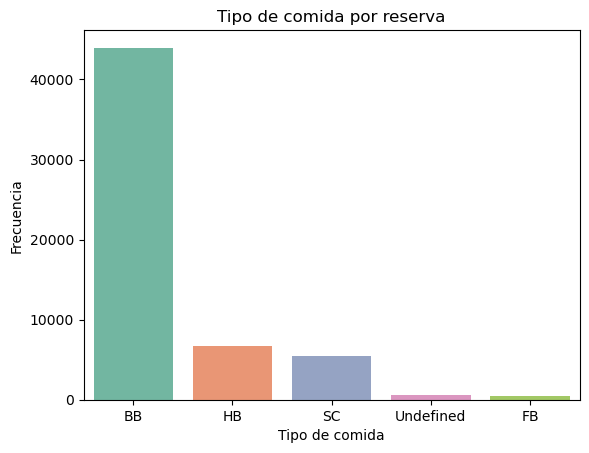

In [141]:
sns.countplot(data=hotelsdf, x = 'meal_type', palette='Set2')
plt.title("Tipo de comida por reserva")
plt.ylabel("Frecuencia")
plt.xlabel("Tipo de comida")

### Reserved room type

#### Valores que toma

In [142]:
reserved_room_typeValores = (hotelsdf["reserved_room_type"].unique())
reserved_room_typeValores.sort()
print(reserved_room_typeValores)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H']


#### Grafica de distribución

Text(0.5, 0, 'Tipo de habitacion')

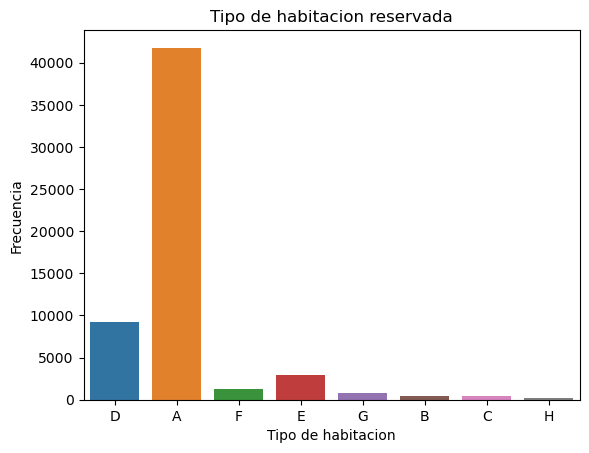

In [143]:
sns.countplot(data=hotelsdf, x = 'reserved_room_type')
plt.title("Tipo de habitacion reservada")
plt.ylabel("Frecuencia")
plt.xlabel("Tipo de habitacion")

Como ya habiamos observado en la cantidad de dias de fin de semana, la mayor cantidad de gente se queda 

# Estado del data frame post analisis univariado

Vamos a observar el estado de nuestro data frame actualmente para observar que efecto tuvo nuestro analisis en el volumen de los datos

In [144]:
pd.concat([hotelsdf.head(2), hotelsdf.sample(5), hotelsdf.tail(2)])

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,agent_id,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,9,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,0,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0
46262,Resort Hotel,14,2015,December,51,19,2,1,2,0,...,0,0,Transient,52.00,0,1,Canceled,2015-12-08,f766cd45-5b6b-46ad-929d-ce15eb1381de,1
51891,Resort Hotel,5,2015,August,31,1,2,3,2,1,...,241,0,Transient,165.32,0,2,Check-Out,2015-08-06,83628826-e8ae-4e67-b83f-f16d18783788,0
8041,City Hotel,151,2017,March,12,24,0,2,2,0,...,9,0,Transient,93.60,0,1,Check-Out,2017-03-26,381d2817-2070-4ca9-bc8a-2cbc1225048e,0
18312,City Hotel,38,2016,March,10,5,2,3,2,0,...,11,0,Transient,52.39,0,0,Check-Out,2016-03-10,e1854502-42c1-4092-9aa8-0c468b2aaf81,0
59372,City Hotel,38,2017,January,2,14,0,1,1,0,...,0,0,Transient,75.00,0,0,Canceled,2016-12-07,095d3b75-4e34-4c29-9497-6e2d473b660f,1
61911,Resort Hotel,143,2015,October,41,10,2,5,2,0,...,96,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1
61912,City Hotel,57,2016,April,17,17,2,5,2,0,...,9,0,Transient,143.29,0,0,Canceled,2016-04-09,7137e599-4442-41fb-b147-4aba9f344e38,1


In [145]:
hotelsdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57121 entries, 0 to 61912
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   hotel_name                       57121 non-null  object 
 1   lead_time                        57121 non-null  int64  
 2   arrival_year                     57121 non-null  int64  
 3   arrival_month                    57121 non-null  object 
 4   arrival_week_number              57121 non-null  int64  
 5   arrival_month_day                57121 non-null  int64  
 6   weekend_nights_num               57121 non-null  int64  
 7   week_nights_num                  57121 non-null  int64  
 8   adult_num                        57121 non-null  int64  
 9   children_num                     57121 non-null  int64  
 10  babies_num                       57121 non-null  int64  
 11  meal_type                        57121 non-null  object 
 12  country           

In [146]:
porcentaje = str(100 - len(hotelsdf) * 100 / len(hotelsDfOriginal))[:5]
print("Vemos que despues del proceso de Ingenieria de caracteristicas, la cantidad de datos se redujo en un " + porcentaje + "%") 

Vemos que despues del proceso de Ingenieria de caracteristicas, la cantidad de datos se redujo en un 7.739%


Ademas observamos que no tenemos mas datos faltantes, visto en como los unicos valores del tipo float64 es average_daily_rate, el cual es un valor de punto flotante.

# Analisis multivariado
## Medicion de la correlacion entre las variables cuantitativas

Una vez hecho el tratado sobre outliers y datos faltantes medimos la correlacion entre las variables cuantitativas encontradas en el dataframe

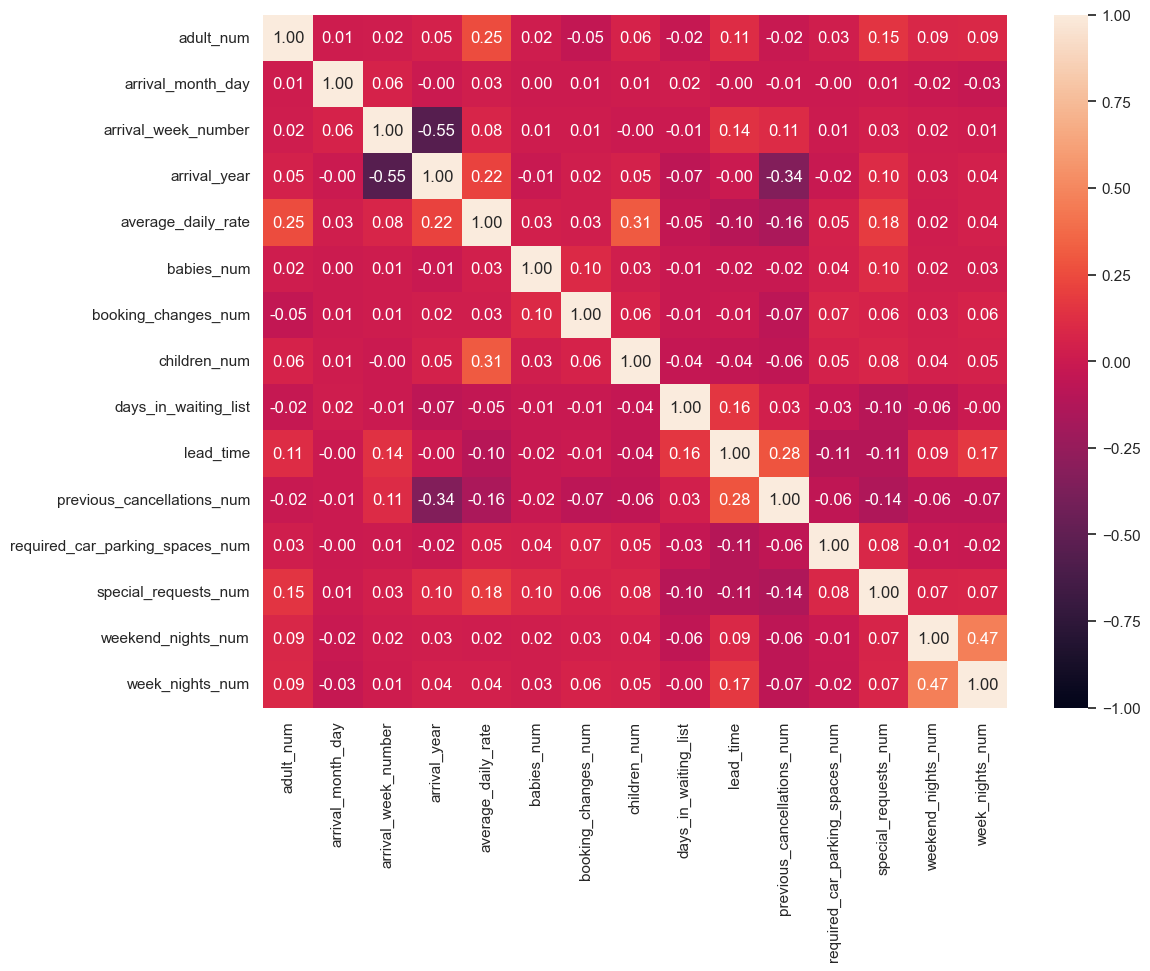

In [147]:
# Este if es se usa para evitar problemas de versiones de pandas entre la version local y la presente en Google Collab
if (pd.__version__) == "1.5.2":
    correlaciones = hotelsdf[cuantitativas].corr(numeric_only=True)

else:
    correlaciones = hotelsdf[cuantitativas].corr()

    
sns.set(style = 'darkgrid')
plt.figure( figsize = (12, 9))
sns.heatmap(data = correlaciones,annot = True, vmin = -1, vmax =1, fmt='.2f')
sns.color_palette("mako", as_cmap=True)
plt.show()

### Week nights number vs Weekend nights number

Como dijimos previamente, analizar por separado las noches de dia de semana y las noches de dias de fin de semana no basta parta estudiar dichas variables. El primer problema que podria surgir es que la cantidad de noches de semana y de fin de semana no guarden una relacion coherente. Al graficarlos debería ocurrir lo siguiente:
- Cuando el numero de noches n de fin de semana es impar, las pendientes de las rectas tienen una variacion de +/- 5 noches de semana
- Cuando el numero de noches n de fin de semana es par, las pendientes de las rectas tienen una variacion de +- 10 noches de semana

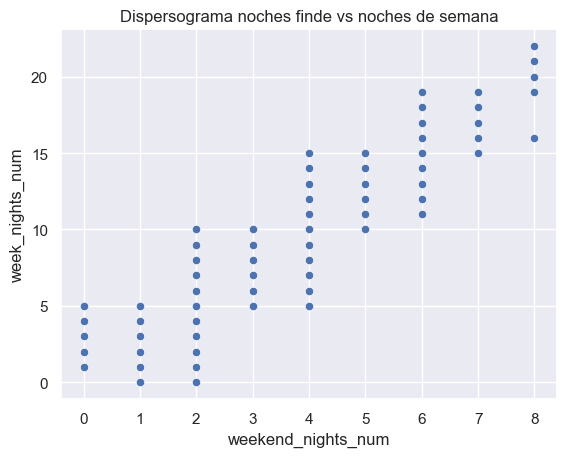

In [148]:
sns.scatterplot(x=hotelsdf.weekend_nights_num,y=hotelsdf.week_nights_num)
plt.title('Dispersograma noches finde vs noches de semana')
plt.show()

Al observar el grafico observamos que todos los puntos se encuentran en los rangos explicados anteriormente.

Sin embargo, ocurre que si bien puede resultar util tener datos sobre las noches de semana y las de fin de semana, un dato que nos podria resultar aun mas util es la cantidad de noches totales de estadia.
Agregamos una columna con dicho dato

In [149]:
hotelsdf["dias_totales"] = hotelsdf["week_nights_num"] + hotelsdf["weekend_nights_num"]

Puesto que ahora tenemos una nueva variable, realizamos un breve analisis univariado sobre la misma para determinar si existen Outliers no detectados en las columans de week y weekend nights number.

Text(0, 0.5, 'Frecuencia')

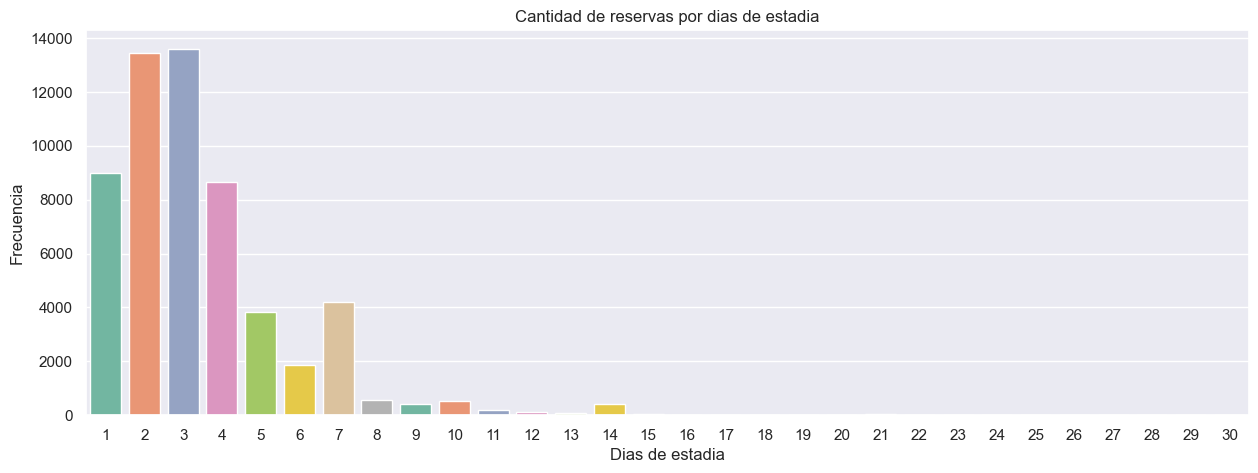

In [150]:
plt.figure(figsize=(15,5))
sns.countplot(data = hotelsdf, x = 'dias_totales', palette= 'Set2')
plt.title('Cantidad de reservas por dias de estadia')
plt.xlabel('Dias de estadia')
plt.ylabel('Frecuencia')

La mayoria de las reservas son de estadias de entre 1 y 7 dias de estadia. En menor medida se observan reservas para estadias entre 8 y 14 dias y por ultimos unas pocas entre 15 y 30 dias. Realizamos un boxplot para darnos una idea de que numero utilizar como corte para determinar outliers.

Text(0, 0.5, 'Frecuencia')

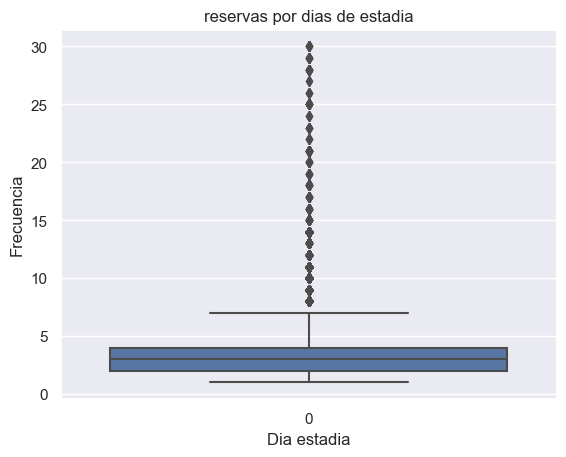

In [151]:
plt.xlabel(xlabel = 'Dia estadia')
sns.boxplot(data = hotelsdf['dias_totales'])
plt.title("reservas por dias de estadia")
plt.ylabel(ylabel = 'Frecuencia')

Segun el grafico se alejarian de la media todos los valores de 8 o mas dias de estadia. Vemos cuantos registros son y que porcentaje representan del total

In [152]:
reservas_mas_de_ocho_dias = hotelsdf[(hotelsdf.dias_totales>=8)].shape[0]
print("hay",reservas_mas_de_ocho_dias,"que representan un porcentaje del total de", reservas_mas_de_ocho_dias*100/hotelsdf.shape[0],"%")

hay 2537 que representan un porcentaje del total de 4.441448854186726 %


Puesto que este valor es muy elevado, apelamos al sentido comun. Rservas de hasta 14 dias de estadia son muy posibles, por lo cual estuidiamos las de mas 15 o mas dias.

Text(0, 0.5, 'Frecuencia')

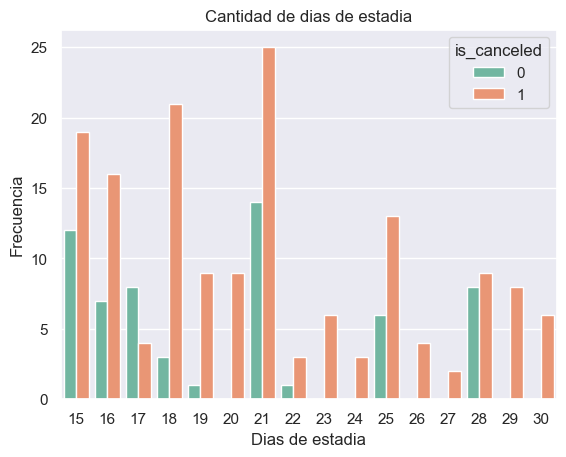

In [153]:
quince_o_mas_dias = hotelsdf[hotelsdf["dias_totales"]>=15]
#plt.figure(figsize=(15,5))
sns.countplot(data = quince_o_mas_dias, x = 'dias_totales', palette= 'Set2', hue = "is_canceled")
plt.title('Cantidad de dias de estadia')
plt.xlabel('Dias de estadia')
plt.ylabel('Frecuencia')

Primero vemos cuantos registros son en total

In [154]:
print("hay",quince_o_mas_dias.shape[0],"que se quedan 15 o mas dias y representan un porcentaje del total de", (quince_o_mas_dias.shape[0])*100/hotelsdf.shape[0],"%")

hay 217 que se quedan 15 o mas dias y representan un porcentaje del total de 0.3798953099560582 %


Luego vemos cuantos de esos cancelan

In [155]:
cancelaron_y_quince_o_mas_dias = hotelsdf[ (hotelsdf.dias_totales>=15) & (hotelsdf.is_canceled == 1) ].shape[0]

print("hay",cancelaron_y_quince_o_mas_dias,"que cancelaron y se quedaron mas de 15 o mas dias.Osea un", cancelaron_y_quince_o_mas_dias*100/quince_o_mas_dias.shape[0],"% de los que se que se quedan mas de 15 dias cancelan")

hay 157 que cancelaron y se quedaron mas de 15 o mas dias.Osea un 72.35023041474655 % de los que se que se quedan mas de 15 dias cancelan


Vemos que el porcentaje de reservas de mas de 15 dias que cancelan es muy alto. Sin embargo, la cantidad de registros con los que ocurre esto son muy pocos. Dejarlos, podria generar ruido al momento de realizar la prediccion. Nos podria llevar, erroneamente a pensar que alguien que se quedo muchos dias cancelaria cuando esto no necesariamente es asi. En el problema q estamos resolviendo, es prefereible no detectar a alguien que cancela, que suponer que alguien cancelaria y que luego no lo haga ya que en terminos de presupuestos, disponibilidad o cualquiera sea el uso que se le de a esta prediccion, no estar preparardo para una reserva perjudicaria mucho mas que estarlo "por las dudas".
Procedemos a eliminarlos

In [156]:
a_eliminar_con_quince_o_mas_dias = hotelsdf[hotelsdf['dias_totales'] >= 15]
hotelsdf.drop(a_eliminar_con_quince_o_mas_dias.index, inplace = True)
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled,dias_totales
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1,3
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0,1
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0,1
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1,7
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56899,Resort Hotel,24,2017,January,4,27,0,2,2,0,...,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1,2
56900,City Hotel,0,2016,September,36,2,0,1,1,0,...,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0,1
56901,City Hotel,10,2017,May,19,8,1,2,1,0,...,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0,3
56902,Resort Hotel,143,2015,October,41,10,2,5,2,0,...,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1,7


Text(0, 0.5, 'Frecuencia')

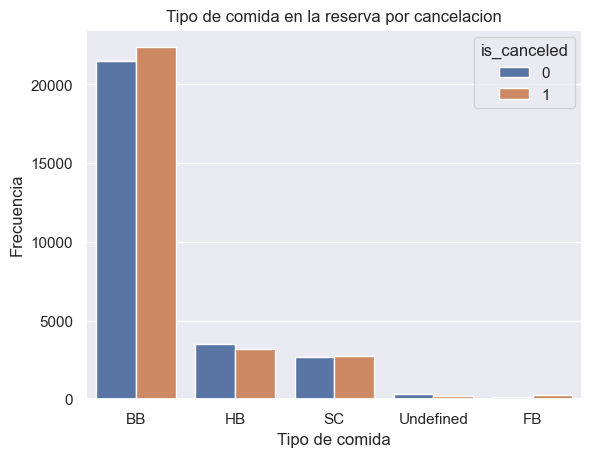

In [157]:
sns.countplot(data = hotelsdf, x='meal_type', hue='is_canceled')
plt.title("Tipo de comida en la reserva por cancelacion")
plt.xlabel("Tipo de comida")
plt.ylabel("Frecuencia")

Una vez analizada la variable contra el target podemos decir que la misma no proporciona suficiente información para el análisis y por lo tanto descartamos la misma para descongestionarla cantidad de variables a usar en el análisis futuro

#### Dias_totales vs Lead_time

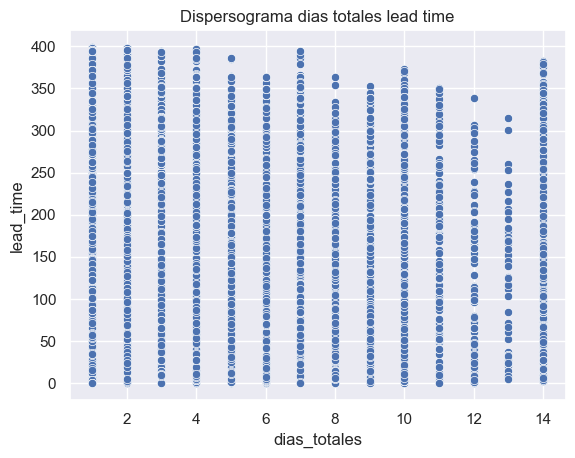

In [158]:
sns.scatterplot(x=hotelsdf.dias_totales,y=hotelsdf.lead_time)
plt.title('Dispersograma dias totales lead time')
plt.show()

Los días totales y la cantidad de tiempo previo desde la reserva hasta la fecha de llegada se distribuyen de manera homogénea. No se identifican outliers

#### ADR y Tipo de cliente

Text(0, 0.5, 'Precio diario promedio')

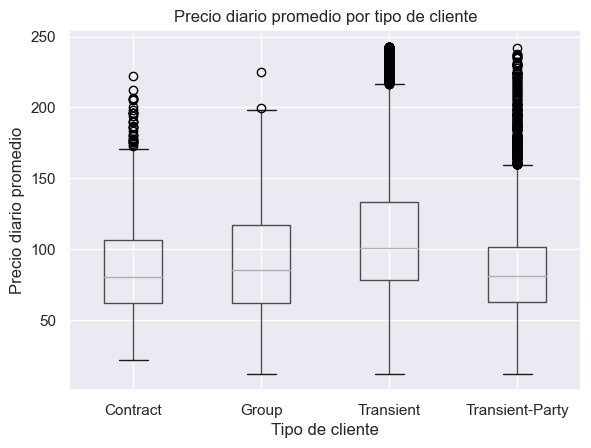

In [159]:
boxplot = hotelsdf.boxplot(column='average_daily_rate', by='customer_type')
plt.title('Precio diario promedio por tipo de cliente')
plt.suptitle("")
plt.xlabel("Tipo de cliente")
plt.ylabel("Precio diario promedio")

Se puede observar en las gráficas que hay valores que se escapan de lo esperado cuando se hace la medición en relación al tipo de cliente, al contabilizar estas observaciones concluimos que son pocas y por lo tanto, eliminamos dichos registros que representan una desviación. También hay que considerar que la media de todos los registros es de aproximadamente 100 (en la unidad correspondiente) y por lo tanto la desviación estándar es muy chica mostrando algunos valores como outliers a pesar de haber pasado por un tratamiento previo 

In [160]:
#obtenemos los indices de los outliers
indices_outliers = hotelsdf[(hotelsdf['customer_type'] == 'Group') & (hotelsdf['average_daily_rate'] > 200)].index
hotelsdf.drop(indices_outliers, inplace = True)
indices_outliers2 = hotelsdf[(hotelsdf['customer_type'] == 'Contract') & (hotelsdf['average_daily_rate'] > 200)].index
hotelsdf.drop(indices_outliers2, inplace = True)
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled,dias_totales
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1,3
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0,1
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0,1
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1,7
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56892,Resort Hotel,24,2017,January,4,27,0,2,2,0,...,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1,2
56893,City Hotel,0,2016,September,36,2,0,1,1,0,...,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0,1
56894,City Hotel,10,2017,May,19,8,1,2,1,0,...,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0,3
56895,Resort Hotel,143,2015,October,41,10,2,5,2,0,...,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1,7


Graficamos nuevamente para verificar que dicho tratamiento no generara una desviación considerable en el análisis

 ```python 
boxplot = hotelsdf.boxplot(column='average_daily_rate', by='customer_type')
plt.title('Precio diario promedio por tipo de cliente')
plt.suptitle("")
plt.xlabel("Tipo de cliente")
plt.ylabel("Precio diario promedio")
```

### ADR y Tipo de habitacion

```python 
boxplot = hotelsdf.boxplot(column='average_daily_rate', by='assigned_room_type')
plt.title('Precio diario promedio por tipo de habitacion')
plt.suptitle("")
plt.xlabel("Tipo de cliente")
plt.ylabel("Precio diario promedio")
```

Del gráfico anterior es claro que aparecen outliers en el precio promedio diario de habitación cuando este es agrupado por tipo de habitación. Se identifican los conjuntos de datos que deben ser eliminados o tratados. 

In [161]:
indices_tipo_k = hotelsdf[(hotelsdf['assigned_room_type'] == 'K') & (hotelsdf['average_daily_rate'] > 160)].index
indices_tipo_i = hotelsdf[(hotelsdf['assigned_room_type'] == 'I') & (hotelsdf['average_daily_rate'] > 210)].index
indices_tipo_b = hotelsdf[(hotelsdf['assigned_room_type'] == 'B') & (hotelsdf['average_daily_rate'] < 30)].index
indices_tipo_b2 = hotelsdf[(hotelsdf['assigned_room_type'] == 'B') & (hotelsdf['average_daily_rate'] > 210)].index
print(f"El total de los datos a eliminar es {len(indices_tipo_k ) + len(indices_tipo_b) + len(indices_tipo_b2) + len(indices_tipo_i)}")

El total de los datos a eliminar es 14


In [162]:
hotelsdf.drop(indices_tipo_k, inplace=True)
hotelsdf.drop(indices_tipo_i, inplace=True)
hotelsdf.drop(indices_tipo_b, inplace=True)
hotelsdf.drop(indices_tipo_b2, inplace=True)
hotelsdf.reset_index(drop=True)

,hotel_name,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_month_day,weekend_nights_num,week_nights_num,adult_num,children_num,...,days_in_waiting_list,customer_type,average_daily_rate,required_car_parking_spaces_num,special_requests_num,reservation_status,reservation_status_date,booking_id,is_canceled,dias_totales
0,City Hotel,49,2016,September,37,5,1,2,1,0,...,0,Transient,115.50,0,1,Canceled,2016-08-25,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1,3
1,Resort Hotel,4,2015,October,44,31,0,1,2,0,...,0,Transient,42.00,1,0,Check-Out,2015-11-01,b1428f80-c56c-4ae4-91a9-6962edae08b1,0,1
2,City Hotel,25,2016,October,42,13,0,1,2,2,...,0,Transient,229.00,0,2,Check-Out,2016-10-14,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0,1
3,City Hotel,26,2016,December,51,12,2,5,2,0,...,0,Transient,75.00,0,0,Canceled,2016-11-29,314f56dc-2e4d-4298-9bdd-27bb008bffff,1,7
4,City Hotel,104,2017,March,12,19,2,5,2,0,...,0,Transient-Party,75.00,0,1,Check-Out,2017-03-26,28c75445-c603-413a-babf-ad377018b592,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56878,Resort Hotel,24,2017,January,4,27,0,2,2,0,...,0,Transient,48.00,0,1,Canceled,2017-01-23,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1,2
56879,City Hotel,0,2016,September,36,2,0,1,1,0,...,0,Transient,149.00,0,0,Check-Out,2016-09-03,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0,1
56880,City Hotel,10,2017,May,19,8,1,2,1,0,...,0,Transient,95.00,0,0,Check-Out,2017-05-11,76fb0e83-59df-43ee-9c33-aec51030ed45,0,3
56881,Resort Hotel,143,2015,October,41,10,2,5,2,0,...,0,Transient,36.05,0,0,Canceled,2015-07-08,01906859-1094-4e37-b13e-b015b594d159,1,7


Mostramos nuevamente la distribución de las variables alteradas

Text(0, 0.5, 'Precio diario promedio')

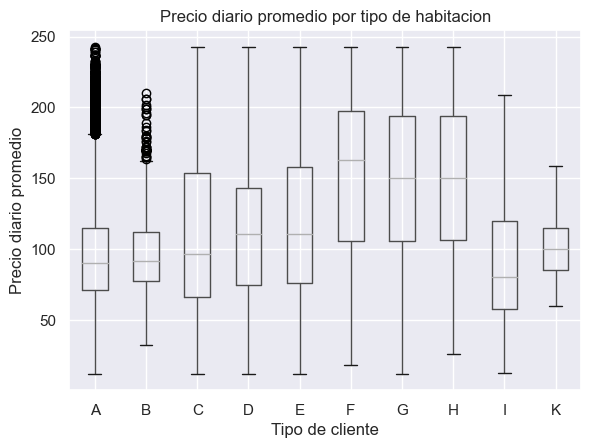

In [163]:
boxplot = hotelsdf.boxplot(column='average_daily_rate', by='assigned_room_type')
plt.title('Precio diario promedio por tipo de habitacion')
plt.suptitle("")
plt.xlabel("Tipo de cliente")
plt.ylabel("Precio diario promedio")

### Adult number, children number y babies number

Realizamos un grafico con la intencion de detectar outliers 

Text(0.5, 0.92, 'Comparacion adultos, niños y bebes')

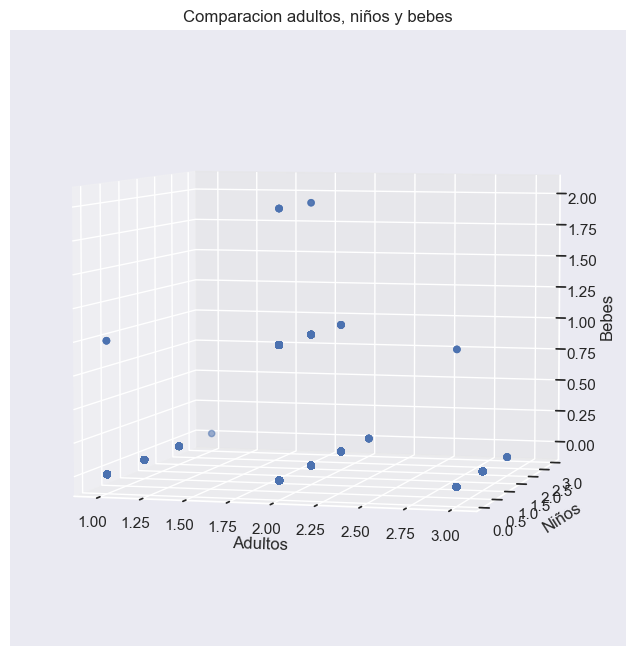

In [164]:
#Visualizacion 3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
x1 = hotelsdf.adult_num
y1 = hotelsdf.children_num
z1 = hotelsdf.babies_num
ax.scatter(x1,y1,z1, label = 'No cancelados')
ax.set_xlabel('Adultos')
ax.set_ylabel('Niños')
ax.set_zlabel('Bebes')
ax.elev = 5  
ax.azim = -75
plt.title('Comparacion adultos, niños y bebes')

A partir del grafico anterior no se puede hacer una observacion relevante en la deteccion de outliers

## Relación contra el target: is_canceled

Vamos a graficar algunas variables haciendo foco en si cancelaron o no. Estas fueron elegidas en base a nuestros analisis multi y univariados y segun el significado que tienen estas variables en el contexto del problema. Optamos por: "lead_time", "average_daily_rate", "previous_cancellations_num", "dias_totales" y "reserved_room_type"

### Lead time

Text(0, 0.5, 'Densidad')

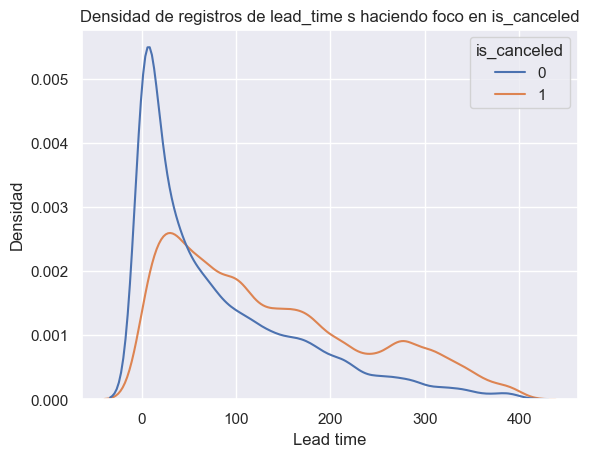

In [165]:
sns.kdeplot(data= hotelsdf, x = "lead_time", hue= "is_canceled")
plt.title("Densidad de registros de lead_time s haciendo foco en is_canceled")
plt.xlabel("Lead time")
plt.ylabel("Densidad")

Estas graficas podrian sugerir que reservas realizadas con mayor anticipacion tendrian mas probabilidad de ser canceladas.

### previous_cancellations_num

Text(0, 0.5, 'Cantidad de reservas')

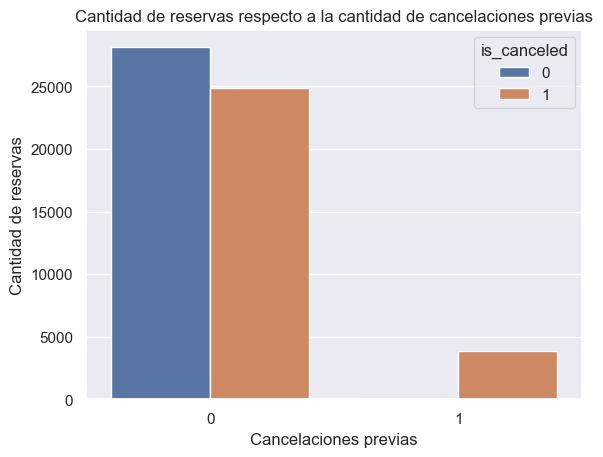

In [166]:
#TODO CAMBIARRRRR
hotelsdf_filtratres = hotelsdf[ hotelsdf["previous_cancellations_num"] <2]
sns.countplot(data= hotelsdf_filtratres, x="previous_cancellations_num",  hue= "is_canceled")
plt.title("Cantidad de reservas respecto a la cantidad de cancelaciones previas")
plt.xlabel("Cancelaciones previas")
plt.ylabel("Cantidad de reservas")

Sin embargo si hacemos zoom en las reservas con una cancelacion previa...

Text(0, 0.5, 'Cantidad de reservas')

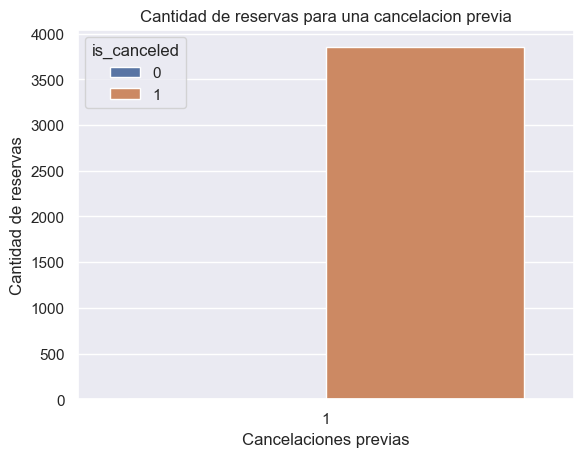

In [167]:
hotelsdf_con_una_cancelaciones = hotelsdf[ hotelsdf["previous_cancellations_num"] ==1]
sns.countplot(data= hotelsdf_con_una_cancelaciones, x="previous_cancellations_num",  hue= "is_canceled")
plt.title("Cantidad de reservas para una cancelacion previa")
plt.xlabel("Cancelaciones previas")
plt.ylabel("Cantidad de reservas")

In [168]:
reservas_con_una_cancelacion = hotelsdf_con_una_cancelaciones.shape[0]
total_reservas_cancelaciones_prev = hotelsdf["previous_cancellations_num"].shape[0]
print("las reservas con 1 cancelacion previa represntan un ", reservas_con_una_cancelacion*100/total_reservas_cancelaciones_prev,"%" )

las reservas con 1 cancelacion previa represntan un  6.775310725524322 %


Observando la grafica vemos que existe un salto muy importante en la cantidad de reservas canceladas cuando la cantidad de reservas canceladas anteriormente es 1. Si bien esta variable parece tener una influencia muy importante sobre el valor ocurre con un numero muy pequeño de registros (un 6%)

### Average_daily_rate

Text(0, 0.5, 'Densidad de registros')

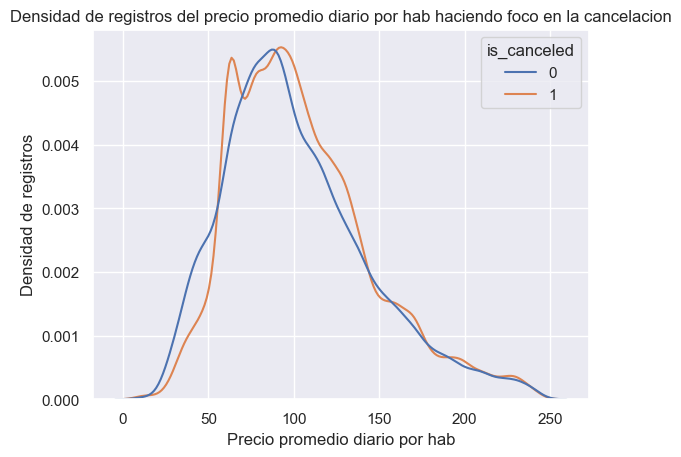

In [169]:
sns.kdeplot(data= hotelsdf, x = "average_daily_rate", hue= "is_canceled")
plt.title("Densidad de registros del precio promedio diario por hab haciendo foco en la cancelacion")
plt.xlabel("Precio promedio diario por hab")
plt.ylabel("Densidad de registros")

Se puede ver que las garficas de ADR haciendo foco en is_cancelled se comportan de manera similiar para todos los valores. No podemos estabecer que exista una influencia directa de esta variable sobre el target.

### Dias Totales

Text(0.5, 1.0, 'Cantidad de reservas por dias de estadia')

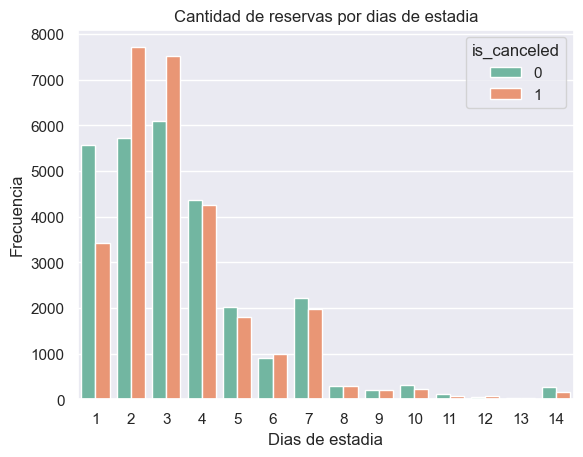

In [170]:
sns.countplot(data = hotelsdf, x = 'dias_totales', palette= 'Set2', hue = "is_canceled")
plt.title('Cantidad de dias de estadia')
plt.xlabel('Dias de estadia')
plt.ylabel('Frecuencia')
plt.title("Cantidad de reservas por dias de estadia")

Podemos ver que no existe una relacion directa entre la cantidad de dias de estadia y si la reserva esta cancelada o no.

### reserved_room_type

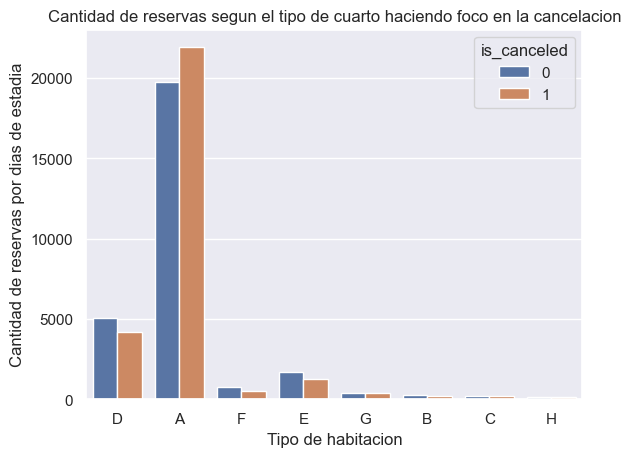

In [171]:
sns.countplot(data=hotelsdf, x = 'reserved_room_type',  hue= "is_canceled")
plt.title('Cantidad de reservas segun el tipo de cuarto haciendo foco en la cancelacion')
plt.xlabel('Tipo de habitacion')
plt.ylabel("Cantidad de reservas por dias de estadia")
plt.show()

Podemos ver que no existe una relacion directa entre el tipo de habitacion elegido y si la reserva esta cancelada o no.

## Conclusion

Como conclusión de esta primera etapa podríamos decir que la única variable que parece tener cierta influencia sobre el target es "lead_time".
Para el resto de las variables, no podemos afirmar que existe una correlación directa entre ellas y el target. Esto se puede observar en sus graficas de distribución en las cuales la cantidad de reservas canceladas es practicamente igual a las no canceladas para casi la totalidad del rango.